# Import

## Dependencies

In [1]:
import time
import numpy as np
import warnings
import pandas as pd
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)

## Data

In [2]:
# Load np array
features = np.load('../50_data/features.npy', allow_pickle=True)

bags_train = np.load('../50_data/bags_train.npy', allow_pickle=True)
id_bags_train = np.load('../50_data/id_bags_train.npy', allow_pickle=True)
date_bags_train = np.load('../50_data/date_bags_train.npy', allow_pickle=True)
y_bag_train = np.load('../50_data/y_round_up_bag_train.npy', allow_pickle=True).astype('int')
y_ins_train = np.load('../50_data/y_ins_train.npy', allow_pickle=True)
bags_validation = np.load('../50_data/bags_validation.npy', allow_pickle=True)
id_bags_validation = np.load('../50_data/id_bags_validation.npy', allow_pickle=True)
y_bag_validation = np.load('../50_data/y_round_up_bag_validation.npy', allow_pickle=True).astype('int')
y_ins_validation = np.load('../50_data/y_ins_validation.npy', allow_pickle=True)

In [3]:
def print_data_stats(list_x, list_y):
    print('- There are {} bags'.format(len(list_x)))
    print('- There are {} labels with values [{}]'.format(len(list_y), ', '.join([str(i) for i in np.unique(list_y, return_counts=True)])))
    
    bags_len = [len(i) for i in list_x]
    print('- Bags length varies between {} and {}'.format(min(bags_len), max(bags_len)))
    
    elem_len = [len(e) for sl in list_x for e in sl]
    print('- Element length varies between {} and {}'.format(min(elem_len), max(elem_len)))

print('Training set:')
print_data_stats(bags_train, y_bag_train)

print('\nValidation set:')
print_data_stats(bags_validation, y_bag_validation)

max_ = max(max([len(i) for i in bags_train]), max([len(i) for i in bags_validation]))

Training set:
- There are 9064 bags
- There are 9064 labels with values [[0 1], [4056 5008]]
- Bags length varies between 1 and 78
- Element length varies between 14 and 14

Validation set:
- There are 4749 bags
- There are 4749 labels with values [[0 1], [1628 3121]]
- Bags length varies between 1 and 73
- Element length varies between 14 and 14


In [4]:
1-4056/(4056+5008)

0.5525154457193292

In [5]:
1-1628/(1628+3121)

0.6571909875763319

In [6]:
1628*.4447

723.9716

## Example

In [7]:
def draw_example(df_bags, df_bags_y, df_bag_id):
    bag_idx = np.random.randint(0, len(df_bags))
    print('Selected bag with id {}'.format(bag_idx))
    print('{} invoice lines'.format(len(df_bags[bag_idx])))
    
    print_bag_details(bag_idx, df_bags_y, df_bag_id)
    
    return bag_idx

def print_bag_details(bag_idx, df_bags_y, df_bag_id, search_admin_customer=False):
    print('bag label = {}'.format(df_bags_y[bag_idx]))
    print('Invoice nr = {}'.format(df_bag_id[bag_idx]))

    if search_admin_customer:
        from admin import admin_sql
        cnxn_sql = admin_sql.AdminSql(r'C:\Users\Ward.RFN\Downloads\credentials\AdminSQL_Credentials_Production.json')
        print('Customer Id = {}'.format(cnxn_sql.sql_query('SELECT CUSTOMER_ID FROM DBA.INVOICE WHERE INVOICE_NR = \'{}\''.format(df_bag_id[bag_idx]))['CUSTOMER_ID'].iloc[0]))

bag_idx = draw_example(bags_train, y_bag_train, id_bags_train)

Selected bag with id 3349
16 invoice lines
bag label = 1
Invoice nr = 2105270


In [8]:
y_ins_train[bag_idx]

array(['OTHER', 'OTHER', 'OTHER', 'ROUND_DOWN', 'ROUND_UP', 'ROUND_UP',
       'ROUND_UP', 'ROUND_DOWN', 'ROUND_DOWN', 'ROUND_DOWN', 'ROUND_UP',
       'NONE', 'ROUND_DOWN', 'OTHER', 'OTHER', 'ROUND_UP'], dtype=object)

In [9]:
pd.DataFrame(data=bags_train[bag_idx], columns=features).head()

INVOICE_RATE_HOUR  REG_OBJECT_INVOICED  REMARK_LENGTH  \
0          83.131577                  1.0           73.0   
1          83.131577                  1.0          103.0   
2          83.131577                  1.0          275.0   
3          83.131577                  1.0          234.0   
4          83.131577                  1.0          267.0   

   INTERNAL_REMARK_LENGTH  LINE_TARIFF  LINE_ORIGINAL_QUANTITY  \
0                    37.0    83.199997                    10.0   
1                    46.0    82.800003                    25.0   
2                   177.0    83.199997                   150.0   
3                     9.0    83.199997                     5.0   
4                     9.0    83.199997                    10.0   

   F_PRESTATION_BY_PM  F_COLLEAGUE_EXP_DAYS  F_PM_EXP_DAYS  F_DISTANCE_5_MIN  \
0                 1.0                3340.0         3340.0               1.0   
1                 1.0                3190.0         3190.0               1.0   
2                 1.0                3332.0         3332.0               0.0   
3                 1.0                3332.0         3332.0               0.0   
4                 1.0                3332.0         3332.0               1.0   

   F_DISTANCE_10_MIN  F_DIFF_SELL_TO_CUST  \
0                0.0                  0.0   
1                0.0                  0.0   
2                0.0                  0.0   
3                1.0                  0.0   
4                0.0                  0.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Compta  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Social  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0

# Limit dataset size

In [10]:
training_set_size = None
validation_set_size = None

if training_set_size:
    bags_train = bags_train[:training_set_size]
    id_bags_train = id_bags_train[:training_set_size]
    y_bag_train = y_bag_train[:training_set_size]
    y_ins_train = y_ins_train[:training_set_size]
    bags_validation = bags_validation[:validation_set_size]
    id_bags_validation = id_bags_validation[:validation_set_size]
    y_bag_validation = y_bag_validation[:validation_set_size]
    y_ins_validation = y_ins_validation[:validation_set_size]

# Pipeline components

## StandarizerBagsList

In [11]:
from preprocessing.standarize_bags import StandarizerBagsList

bag_standardizer = StandarizerBagsList()

start_time = time.time()
bag_standardizer.fit(bags_train)
print("Standardizer fitting time: {:.2f} sec".format(time.time() - start_time))

# Print average and stdev time registration
pd.DataFrame(data=[bag_standardizer.mean, bag_standardizer.std], columns=features)

Standardizer fitting time: 0.12 sec


INVOICE_RATE_HOUR  REG_OBJECT_INVOICED  REMARK_LENGTH  \
0          98.907386                  0.0     102.834566   
1          45.470697                  1.0      77.758861   

   INTERNAL_REMARK_LENGTH  LINE_TARIFF  LINE_ORIGINAL_QUANTITY  \
0                9.900105    89.905470               38.813549   
1               26.826987    11.181641               60.075869   

   F_PRESTATION_BY_PM  F_COLLEAGUE_EXP_DAYS  F_PM_EXP_DAYS  F_DISTANCE_5_MIN  \
0                 0.0           1977.034479    1825.899919               0.0   
1                 1.0           1853.295854    1531.398622               1.0   

   F_DISTANCE_10_MIN  F_DIFF_SELL_TO_CUST  \
0                0.0                  0.0   
1                1.0                  1.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Compta  \
0                                      0.0   
1                                      1.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Social  
0                                      0.0  
1                                      1.0

### Example

In [12]:
bag_idx = draw_example(bags_validation, y_bag_validation, id_bags_validation)

Selected bag with id 1938
21 invoice lines
bag label = 1
Invoice nr = 2205593


In [13]:
# Show example bag
pd.DataFrame(data=bags_validation[bag_idx], columns=features).head(3)

INVOICE_RATE_HOUR  REG_OBJECT_INVOICED  REMARK_LENGTH  \
0          73.017738                  1.0          198.0   
1          73.017738                  1.0          118.0   
2          73.017738                  1.0          172.0   

   INTERNAL_REMARK_LENGTH  LINE_TARIFF  LINE_ORIGINAL_QUANTITY  \
0                   113.0   108.500000                    30.0   
1                     0.0    83.199997                    60.0   
2                     0.0    83.199997                    15.0   

   F_PRESTATION_BY_PM  F_COLLEAGUE_EXP_DAYS  F_PM_EXP_DAYS  F_DISTANCE_5_MIN  \
0                 0.0                2771.0         2475.0               0.0   
1                 0.0                6967.0         2477.0               0.0   
2                 1.0                2470.0         2470.0               0.0   

   F_DISTANCE_10_MIN  F_DIFF_SELL_TO_CUST  \
0                0.0                  0.0   
1                0.0                  0.0   
2                0.0                  0.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Compta  \
0                                      1.0   
1                                      1.0   
2                                      1.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Social  
0                                      0.0  
1                                      0.0  
2                                      0.0

In [14]:
# Transfrom one bag
pd.DataFrame(data=bag_standardizer.transform([bags_validation[bag_idx]])[0], columns=features).head(3)

INVOICE_RATE_HOUR  REG_OBJECT_INVOICED  REMARK_LENGTH  \
0           -0.56937                  1.0       1.223853   
1           -0.56937                  1.0       0.195032   
2           -0.56937                  1.0       0.889486   

   INTERNAL_REMARK_LENGTH  LINE_TARIFF  LINE_ORIGINAL_QUANTITY  \
0                3.843141     1.662952               -0.146707   
1               -0.369035    -0.599686                0.352662   
2               -0.369035    -0.599686               -0.396391   

   F_PRESTATION_BY_PM  F_COLLEAGUE_EXP_DAYS  F_PM_EXP_DAYS  F_DISTANCE_5_MIN  \
0                 0.0              0.428407       0.423861               0.0   
1                 0.0              2.692482       0.425167               0.0   
2                 1.0              0.265994       0.420596               0.0   

   F_DISTANCE_10_MIN  F_DIFF_SELL_TO_CUST  \
0                0.0                  0.0   
1                0.0                  0.0   
2                0.0                  0.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Compta  \
0                                      1.0   
1                                      1.0   
2                                      1.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Social  
0                                      0.0  
1                                      0.0  
2                                      0.0

### Standardize data set

In [15]:
start_time = time.time()
bags_train_std = bag_standardizer.transform(bags_train)
print("Standardizer transform time (train set): {:.2f} sec".format(time.time() - start_time))

start_time = time.time()
bags_validation_std = bag_standardizer.transform(bags_validation)
print("Standardizer transform time (validation set): {:.2f} sec".format(time.time() - start_time))

Standardizer transform time (train set): 0.22 sec
Standardizer transform time (validation set): 0.07 sec


## MILESMapping

In [16]:
from bag_representation.miles_mapping import *

bag_miles_mapping = MILESMapping(sigma2=4.5**2)


start_time = time.time()
bag_miles_mapping.fit(bags_train_std)
print("MILES Mapping fitting time: {:.2f} sec".format(time.time() - start_time))

MILES Mapping fitting time: 0.05 sec


### Example

In [17]:
bag_idx = draw_example(bags_validation_std, y_bag_validation, id_bags_validation)

Selected bag with id 1668
3 invoice lines
bag label = 0
Invoice nr = 2205044


In [18]:
# Show example bag
pd.DataFrame(data=bags_validation_std[bag_idx], columns=features).head(3)

INVOICE_RATE_HOUR  REG_OBJECT_INVOICED  REMARK_LENGTH  \
0           -0.34544                  1.0       0.195032   
1           -0.34544                  1.0       0.452237   
2           -0.34544                  1.0      -0.949532   

   INTERNAL_REMARK_LENGTH  LINE_TARIFF  LINE_ORIGINAL_QUANTITY  \
0                0.898345    -0.599686                2.849504   
1               -0.369035    -0.599686                3.348873   
2                1.867519    -0.599686               -0.396391   

   F_PRESTATION_BY_PM  F_COLLEAGUE_EXP_DAYS  F_PM_EXP_DAYS  F_DISTANCE_5_MIN  \
0                 0.0             -1.060831      -0.517762               0.0   
1                 0.0             -0.505604      -1.180555               0.0   
2                 1.0             -1.054356      -1.177290               0.0   

   F_DISTANCE_10_MIN  F_DIFF_SELL_TO_CUST  \
0                0.0                  0.0   
1                0.0                  0.0   
2                0.0                  0.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Compta  \
0                                      1.0   
1                                      1.0   
2                                      1.0   

   PROJECT_TYPE_DESCRIPTION_Dossier Social  
0                                      0.0  
1                                      0.0  
2                                      0.0

In [19]:
# Transfrom one bag
test, test_closest = bag_miles_mapping.transform([bags_validation_std[bag_idx]])
test, test_closest = test[0], test_closest[0] 
print('length = {}; max = {:.2f}; min = {:.2f}'.format(len(test), test.max(), test.min()))
test

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]

length = 80745; max = 0.99; min = 0.00


array([0.46717967, 0.47302672, 0.48291654, ..., 0.29592879, 0.38537524,
       0.38535951])

In [20]:
from utils.utils import bags2instances

# Intermediary instance pool
iip = bags2instances(bags_train)

# Show similar lines from iip compared with example bag
print('{} lines in iip are similar to one of the lines of this bag.'.format(len(np.where(test > .999)[0])))
pd.DataFrame(data=iip[np.where(test > .999)], columns=features).head(50)

0 lines in iip are similar to one of the lines of this bag.


Empty DataFrame
Columns: [INVOICE_RATE_HOUR, REG_OBJECT_INVOICED, REMARK_LENGTH, INTERNAL_REMARK_LENGTH, LINE_TARIFF, LINE_ORIGINAL_QUANTITY, F_PRESTATION_BY_PM, F_COLLEAGUE_EXP_DAYS, F_PM_EXP_DAYS, F_DISTANCE_5_MIN, F_DISTANCE_10_MIN, F_DIFF_SELL_TO_CUST, PROJECT_TYPE_DESCRIPTION_Dossier Compta, PROJECT_TYPE_DESCRIPTION_Dossier Social]
Index: []

### Apply MILES Mapping on data set

In [21]:
bags_train_std_miles, bags_train_std_miles_closest = bag_miles_mapping.transform(bags_train_std)

bags_validation_std_miles, bags_validation_std_miles_closest = bag_miles_mapping.transform(bags_validation_std)

100%|██████████████████████████████████████████████████████████████████████████████| 4749/4749 [11:30<00:00,  6.88it/s]


# Exploratory data analysis

The bag represantation moved to a 1d vector feature space with a **very** high dimensionality.

In fact, the dimensionality of the mapped feature space is equal to the amount of instances in all bags of the training data set

In [22]:
df_bags_train_std_miles = pd.DataFrame(data=bags_train_std_miles)
df_bags_validation_std_miles = pd.DataFrame(data=bags_validation_std_miles)
df_bags_train_std_miles.head(3)

0         1         2         3         4         5         6      \
0  1.000000  1.000000  1.000000  0.784217  0.822971  0.772796  0.778120   
1  0.749913  0.810638  0.822971  1.000000  1.000000  1.000000  1.000000   
2  0.760941  0.815121  0.838553  0.556827  0.557639  0.537753  0.553643   

      7         8         9         10        11        12        13     \
0  0.778804  0.778923  0.772652  0.705723  0.659082  0.756629  0.743247   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.561024  0.560914  0.561417  0.605437  0.578015  0.505640  0.575872   

      14        15        16        17        18        19        20     \
0  0.697262  0.658625  0.072824  0.706699  0.696645  0.658022  0.705488   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.602184  0.578062  0.155777  0.543188  0.602217  0.578076  0.549968   

     21        22        23        24        25        26        27     \
0  0.66324  0.657505  0.366597  0.791579  0.776906  0.775871  0.700972   
1  1.00000  1.000000  0.292635  0.605437  0.595623  0.533738  0.536506   
2  0.57819  0.578053  1.000000  1.000000  1.000000  1.000000  1.000000   

      28        29        30        31        32        33        34     \
0  0.807894  0.708544  0.589577  0.838553  0.697866  0.787932  0.614703   
1  0.561720  0.578190  0.485029  0.560915  0.577103  0.602217  0.476020   
2  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

      35        36        37        38        39        40        41     \
0  0.670716  0.925098  0.862813  0.374106  0.811566  0.843591  0.904806   
1  0.522362  0.918343  0.899107  0.450908  0.933965  0.844296  0.941363   
2  1.000000  0.711724  0.762604  0.796509  0.797884  0.722903  0.741253   

      42        43        44        45        46        47        48     \
0  0.856969  0.805321  0.841424  0.811213  0.789677  0.913753  0.929370   
1  0.854005  0.855942  0.895408  0.826854  0.860881  0.896106  0.742977   
2  0.732701  0.741110  0.773159  0.758849  0.715172  0.755106  0.827434   

      49        50        51        52        53        54        55     \
0  0.771416  0.928526  0.852506  0.797874  0.766533  0.858681  0.799566   
1  0.679594  0.738404  0.679981  0.743711  0.679746  0.698788  0.720170   
2  0.842805  0.809434  0.834755  0.806020  0.831799  0.892157  0.855508   

      56        57        58        59        60        61        62     \
0  0.634983  0.794500  0.691611  0.835090  0.900630  0.976790  0.873043   
1  0.655896  0.743711  0.714545  0.685598  0.839274  0.839347  0.832482   
2  0.856116  0.813343  0.818670  0.879425  0.824379  0.811967  0.837153   

      63        64        65        66        67        68        69     \
0  0.764140  0.801349  0.594228  0.762280  0.876981  0.769124  0.831089   
1  0.840528  0.837837  0.612176  0.791319  0.835738  0.839313  0.831305   
2  0.846636  0.876572  0.886778  0.841804  0.840138  0.845244  0.831738   

      70        71        72        73        74        75        76     \
0  0.755776  0.755741  0.751219  0.825432  0.649899  0.612565  0.650597   
1  0.832153  0.629824  0.626772  0.632128  0.440621  0.478527  0.496336   
2  0.872059  0.811118  0.810359  0.791058  0.546821  0.595425  0.614980   

      77        78        79        80        81        82        83     \
0  0.652795  0.550901  0.609659  0.761672  0.651688  0.650520  0.649641   
1  0.497435  0.458376  0.475741  0.596880  0.653851  0.654930  0.651750   
2  0.614981  0.629807  0.584312  0.696674  0.644029  0.636437  0.631546   

      84        85        86        87        88        89        90     \
0  0.625649  0.650126  0.433314  0.697937  0.647869  0.646626  0.589511   
1  0.694389  0.745669  0.532635  0.732349  0.745145  0.715624  0.740704   
2  0.539490  0.529177  0.542606  0.507829  0.528463  0.544094  0.571745   

      91        92        93        94        95        96        97     \
0  0.644855  0.493506 

## Principle Component analysis

In [23]:
from sklearn.decomposition import PCA
class PCAFeatureExtractor():
    
    def __init__(self, n_components, data):
        self.n_components = n_components
        self.data = data
        
        # Get mean vector
        self.mean = np.mean(self.data, axis=0)
        
        #train PCA
        self.pca = PCA(n_components=self.n_components, whiten=False).fit(self.data)
        
    def plot_explained_variance(self, bound_1, bound_2):
        fig, ax = plt.subplots(1,1, figsize=(10,8))
        ax.plot(self.pca.explained_variance_ratio_.cumsum(), lw=1, color='black')
        
        ax.axhline(y=bound_1, lw=1, color='black', linestyle='-.', label=str(bound_1))
        ax.axvline(x=6.25, lw=1, color='black', linestyle='-.')
        
        ax.axhline(y=bound_2, lw=1, color='black', linestyle='--', label=str(bound_2))
        ax.axvline(x=32, lw=1, color='black', linestyle='--')
        
        ax.legend()
        
        ax.set_xlabel('Number of components')
        ax.set_ylabel('Explained variance')
        
        print("{} components explain {}% of the variance".format(np.where(self.pca.explained_variance_ratio_.cumsum() < bound_1)[0].shape[0], bound_1))
        print("{} components explain {}% of the variance".format(np.where(self.pca.explained_variance_ratio_.cumsum() < bound_2)[0].shape[0], bound_2))
        print("{} components explain {}% of the variance".format(self.n_components, self.pca.explained_variance_ratio_.cumsum()[-1]))
        
        return self.pca.explained_variance_ratio_.cumsum()
        
    def transform(self, data):
        return self.pca.transform(data)
    
    def __call__(self, data):
        return data

In [24]:
pca_feature_extractor = PCAFeatureExtractor(n_components = 50, data = df_bags_train_std_miles)

7 components explain 0.95% of the variance
32 components explain 0.99% of the variance
50 components explain 0.9938381016696259% of the variance


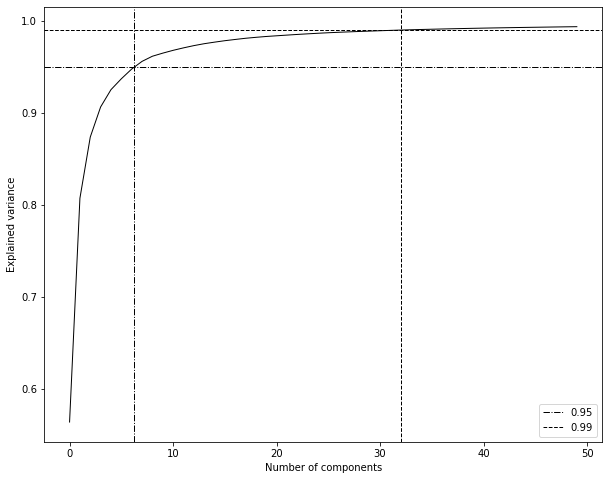

In [25]:
test = pca_feature_extractor.plot_explained_variance(.95, .99)

### Transform data using PCA

In [26]:
df_bags_train_std_miles_pca = pd.DataFrame(pca_feature_extractor.transform(df_bags_train_std_miles))
df_bags_validation_std_miles_pca = pd.DataFrame(pca_feature_extractor.transform(bags_validation_std_miles))

In [27]:
df_bags_train_std_miles_pca.head()

0          1          2          3          4         5         6   \
0  19.252771  38.942957   3.877161 -14.057841 -10.536707 -7.191190 -5.696474   
1  46.871076  46.447902   1.954288   2.606271 -11.755631  5.769096 -2.935494   
2  13.790174  33.080499  -7.333515 -21.838867  13.702769 -5.157090  2.072723   
3  18.992110  48.047251  -9.438177  -8.852216  -4.130386  2.451369  6.715515   
4  12.883485  34.395650 -19.134434  -9.068757   0.574423 -4.028791 -6.940932   

         7         8         9         10        11        12        13  \
0  2.935697  4.156906  2.684127  3.013045 -3.987912  1.433693  0.559167   
1 -1.016793 -2.286528 -1.275756  3.671563  2.842111 -0.811306  0.364353   
2 -1.828527 -3.717893 -0.768715 -3.827990  0.854496 -1.837359 -1.216420   
3 -2.179455  0.057074  1.992372  2.008101  1.131506 -2.201383 -1.558018   
4 -0.857225 -3.786310  1.089753 -1.235526 -1.819061  1.011918  1.363264   

         14        15        16        17        18        19        20  \
0  1.375915 -0.097791 -0.827082  0.363951  1.788277  2.684218 -1.975719   
1  0.763209  4.672886 -0.810276 -1.102318  2.088928 -0.751605  1.500871   
2 -1.254735 -2.729620 -0.665024 -1.764840 -2.132818 -0.186667 -1.226951   
3 -0.458836 -1.227921 -2.036740 -2.708638 -2.310288  0.092335 -0.390303   
4 -2.590161 -0.313799  0.405122 -0.400055 -0.517263 -1.210004  0.742852   

         21        22        23        24        25        26        27  \
0 -0.416007 -1.246601  0.432801  2.264348  0.092968 -0.251602 -0.283137   
1  1.973966 -0.783666 -1.428554  0.018071  0.466339 -0.676749  0.710099   
2  1.533229  1.624178  0.529068 -1.658667  0.150039 -0.334346  0.106513   
3  1.671002  0.274896 -0.608136  1.277383 -0.090196 -1.004347 -1.083627   
4 -1.431473  0.958070  0.700654  0.101980  0.382796 -0.564950  0.346350   

         28        29        30        31        32        33        34  \
0 -0.527904  0.180830  0.195630  0.210187  1.351851  0.343787 -0.905858   
1  1.515592 -1.011460 -0.591157 -1.907309  0.294622  0.132360 -0.689542   
2 -0.918305  0.801551 -1.620594 -0.027239 -1.019528  1.074574  0.365452   
3  0.866710 -0.247823  2.319959 -1.240860  1.823981  0.554736 -0.514473   
4 -0.749322 -0.852681 -0.478145  0.652616 -0.897239  0.348171  0.585223   

         35        36        37        38        39        40        41  \
0  0.234211 -0.330241 -0.118445  0.297842 -0.512608  0.755726  0.037382   
1 -0.994871 -0.356959 -0.508802  1.080905 -0.283779 -0.009646 -0.324740   
2  1.232354 -0.690106  0.567278 -0.941500  0.682613  0.848878 -0.558021   
3 -0.601894  0.252503 -0.061366 -1.230418  0.467328 -0.203846 -0.179074   
4  0.173234 -0.069838 -0.011933  0.873192 -0.735106 -0.178111 -1.108039   

         42        43        44        45        46        47        48  \
0  0.942708  0.024359  0.164627  0.133221 -0.299505  0.147463  0.411941   
1 -0.227194  0.261508  0.617325  0.414454 -0.254985 -0.148812 -0.270170   
2  0.797952 -0.167935 -0.989753  0.150336 -0.312238  0.294149  0.984551   
3  0.198788  0.454746 -0.511305  0.056327  0.417819 -0.106023 -0.535971   
4 -0.213504 -1.096875 -0.137187  0.464755  0.794746  0.214661  0.576465   

         49  
0 -0.442077  
1 -0.203463  
2  0.088699  
3  0.424356  
4 -0.041973

## PCA Feature space plots

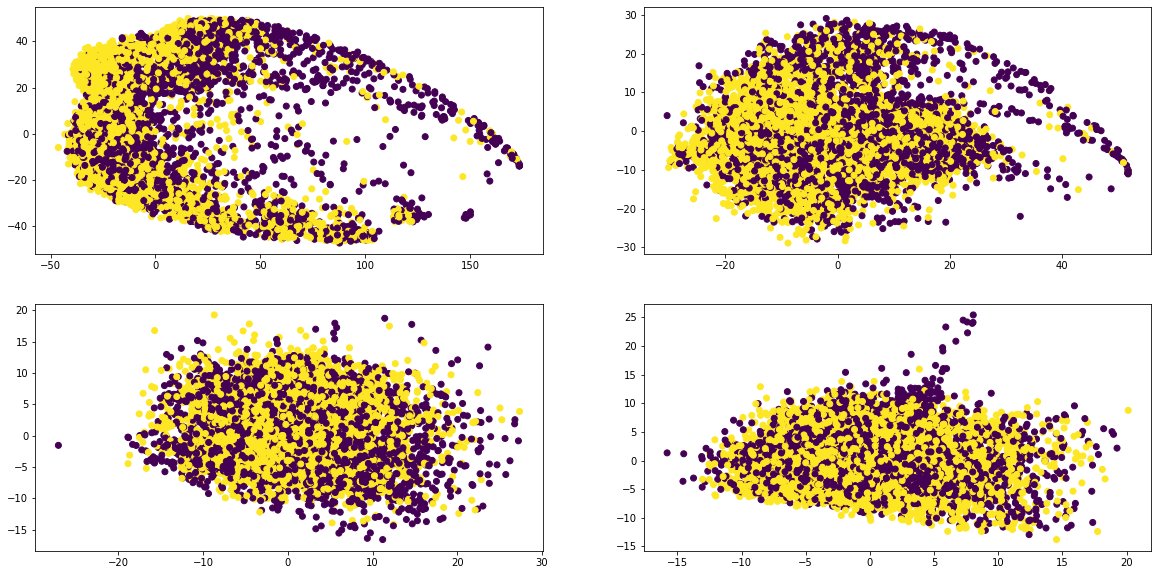

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
ax1.scatter(df_bags_train_std_miles_pca.iloc[:,0], df_bags_train_std_miles_pca.iloc[:,1], c=y_bag_train, label=y_bag_train)
ax2.scatter(df_bags_train_std_miles_pca.iloc[:,2], df_bags_train_std_miles_pca.iloc[:,3], c=y_bag_train, label=y_bag_train)
ax3.scatter(df_bags_train_std_miles_pca.iloc[:,4], df_bags_train_std_miles_pca.iloc[:,5], c=y_bag_train, label=y_bag_train)
ax4.scatter(df_bags_train_std_miles_pca.iloc[:,6], df_bags_train_std_miles_pca.iloc[:,7], c=y_bag_train, label=y_bag_train)

# Model evaluation

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

def model_evaluation(y, y_predicted, min_recall=.95, prob_col=1):
    y_predicted = np.array([float(i) for i in y_predicted.iloc[:, prob_col]])
    
    #Get ROC values for entire validation set
    fpr, tpr, _ = roc_curve(y_true=y, y_score=y_predicted)
    print("AUC = {}".format(roc_auc_score(y, y_predicted)))
    
    # Get Precision/Recall
    precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=y_predicted)
    thresholds = [0] + thresholds.tolist()
    min_recall_threshold = thresholds[np.abs(recall - min_recall).argmin()]
    
    # Calulate specificity at this rate
    tn, fp, fn, tp = confusion_matrix(y, y_predicted>min_recall_threshold).ravel()
    specificity = (tn / (tn+fp))*100
    
    print('Recall of {:.2f} % reached on {:.3f} threshold. This equals a {:.3f} % specificity'.format(min_recall*100, min_recall_threshold, specificity))
    
    # Create figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)
    
    # Figure 1 - ROC
    axs[0].plot(fpr, tpr, lw=1, color='black')
    axs[0].plot([0, 1], [0, 1], color='black', linestyle='dashed')
    axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 2 - Precision/Recall
    axs[1].plot(recall, precision, lw=1, color='black')
    axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    # Figure 3 - Precision/Recall
    axs[2].plot(thresholds, precision, label='precision', lw=1, color='black', ls='dotted')
    axs[2].plot(thresholds, recall, label='recall', lw=1, color='black', ls='dashed')
    axs[2].axhline(min_recall, lw=1, color='red')
    axs[2].axvline(min_recall_threshold, ls='--', lw=1, color='black')
    axs[2].legend()
    axs[2].set(xlabel='Threshold', ylabel='Recall/Precision', title='Precision/Recall', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    
    return min_recall_threshold, specificity, roc_auc_score(y, y_predicted)

# Classifier

In [30]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [31]:
svc = SVC(C=0.1, kernel='linear', probability=True)

b_svc = BaggingClassifier(svc, n_estimators=15)

start_time = time.time()
b_svc.fit(df_bags_train_std_miles_pca, y_bag_train)
print('{:.2f} seconds'.format(time.time() - start_time))

577.34 seconds


In [32]:
y_bag_validation_pred = pd.DataFrame(b_svc.predict_proba(df_bags_validation_std_miles_pca))

AUC = 0.8357711138069998
Recall of 95.00 % reached on 0.291 threshold. This equals a 48.280 % specificity


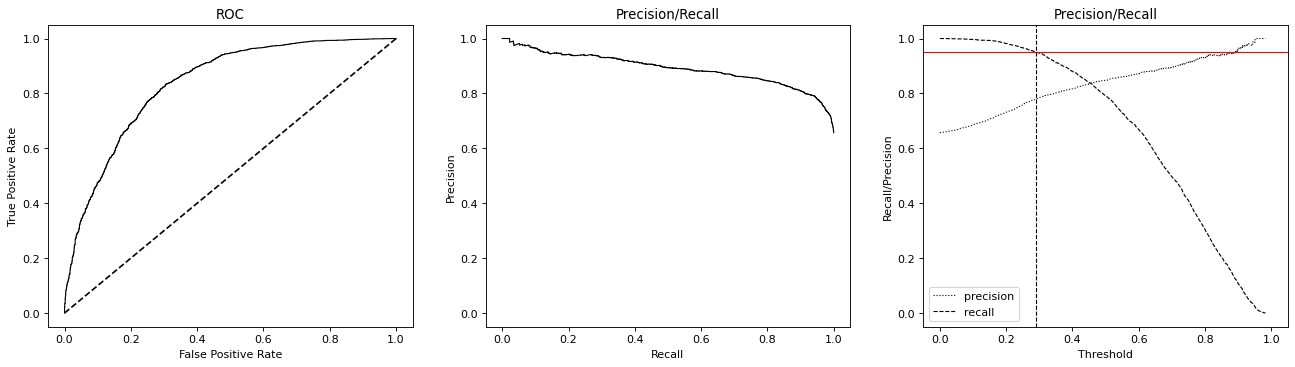

In [33]:
min_recall_threshold, specificity, auc_score = model_evaluation(y_bag_validation, y_bag_validation_pred, min_recall=.95, prob_col=1)

# Active Learning experiments

Loop over months, retrain an evaluate performance

In [34]:
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier

In [35]:
invoice_months = date_bags_train[:, 1]
np.unique(invoice_months, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
 array([1078, 1073, 1105, 1457,  731, 1305, 1249,  986,   80], dtype=int64))

In [36]:
len(invoice_months)

9064

## Passive Learning

In [37]:
# Fit model
al_passive = ActiveLearner(
    estimator=BaggingClassifier(SVC(C=0.1, kernel='linear', probability=True), n_estimators=15),
    X_training=None, 
    y_training=None
)

 12%|██████████▌                                                                         | 1/8 [00:14<01:42, 14.59s/it]

AUC = 0.8171790604504479
Recall of 95.00 % reached on 0.494 threshold. This equals a 42.936 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])


AUC = 0.8177208842059851
Recall of 95.00 % reached on 0.361 threshold. This equals a 40.786 % specificity


 25%|█████████████████████                                                               | 2/8 [01:01<03:23, 33.89s/it]C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [02:24<04:41, 56.21s/it]

AUC = 0.8302485658301102
Recall of 95.00 % reached on 0.360 threshold. This equals a 45.393 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [05:09<06:36, 99.06s/it]

AUC = 0.8315239083422359
Recall of 95.00 % reached on 0.323 threshold. This equals a 45.700 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 62%|███████████████████████████████████████████████████▉                               | 5/8 [08:50<07:09, 143.06s/it]

AUC = 0.8338754195050254
Recall of 95.00 % reached on 0.310 threshold. This equals a 46.499 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [14:30<07:00, 210.11s/it]

AUC = 0.8326864775118541
Recall of 95.00 % reached on 0.293 threshold. This equals a 47.359 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [22:07<04:50, 290.65s/it]

AUC = 0.8330745910047415
Recall of 95.00 % reached on 0.299 threshold. This equals a 48.771 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [31:51<00:00, 238.95s/it]

AUC = 0.8356929793969206
Recall of 95.00 % reached on 0.295 threshold. This equals a 48.526 % specificity


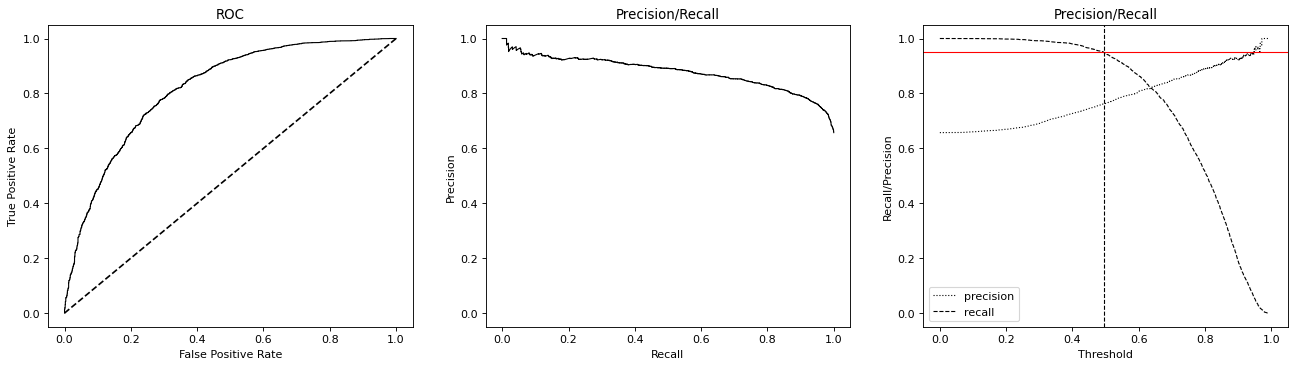

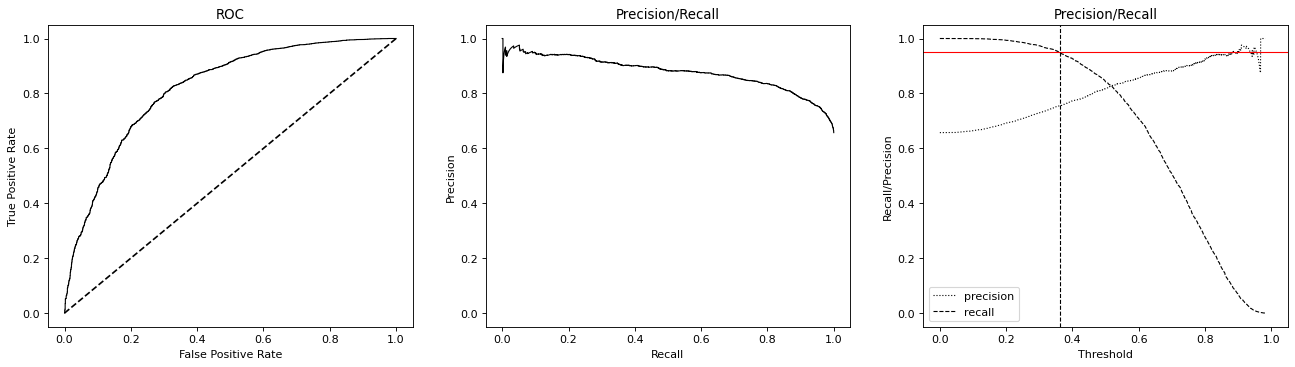

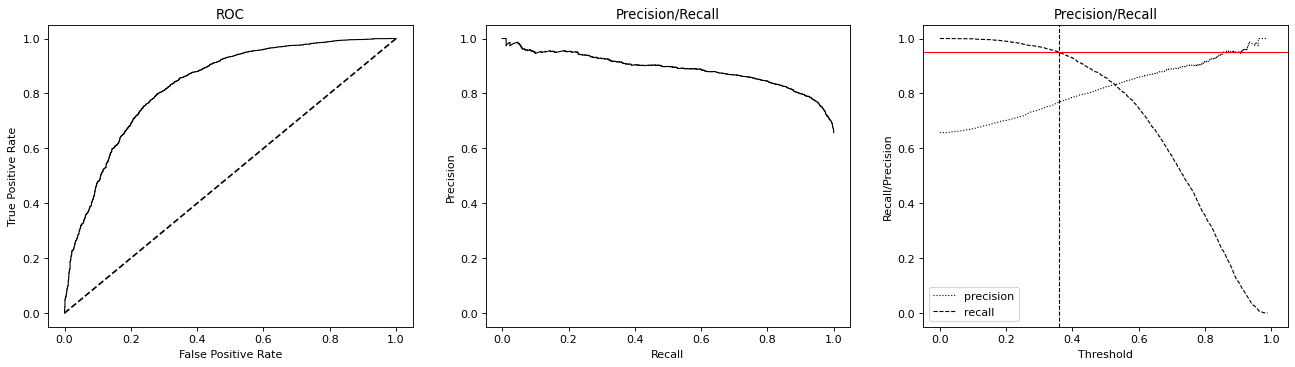

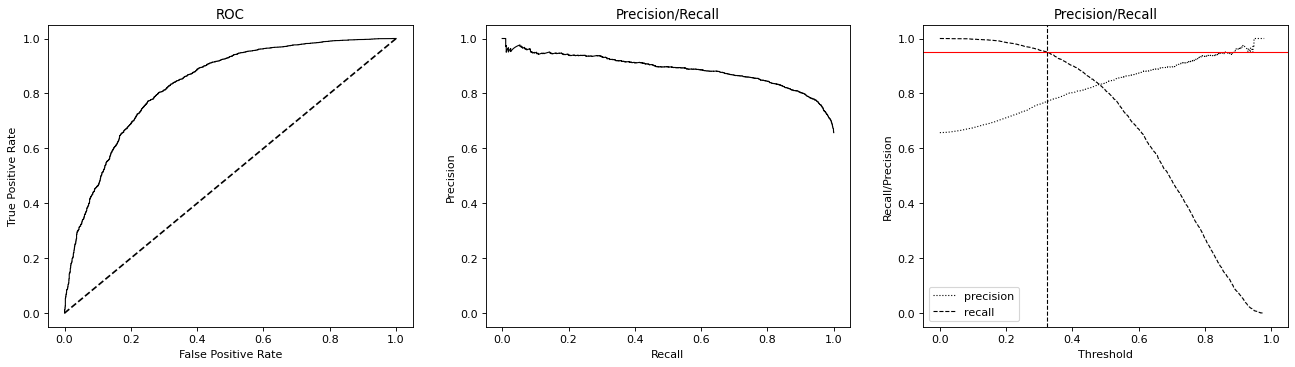

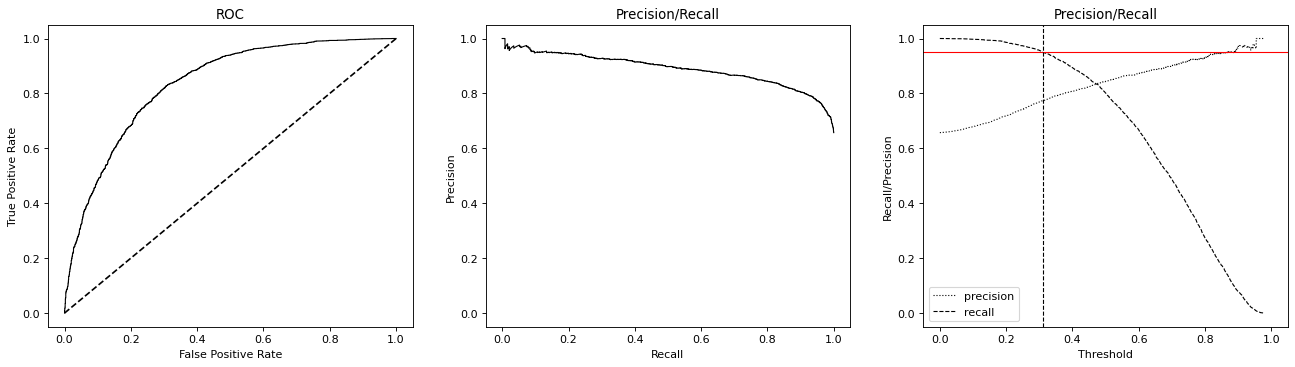

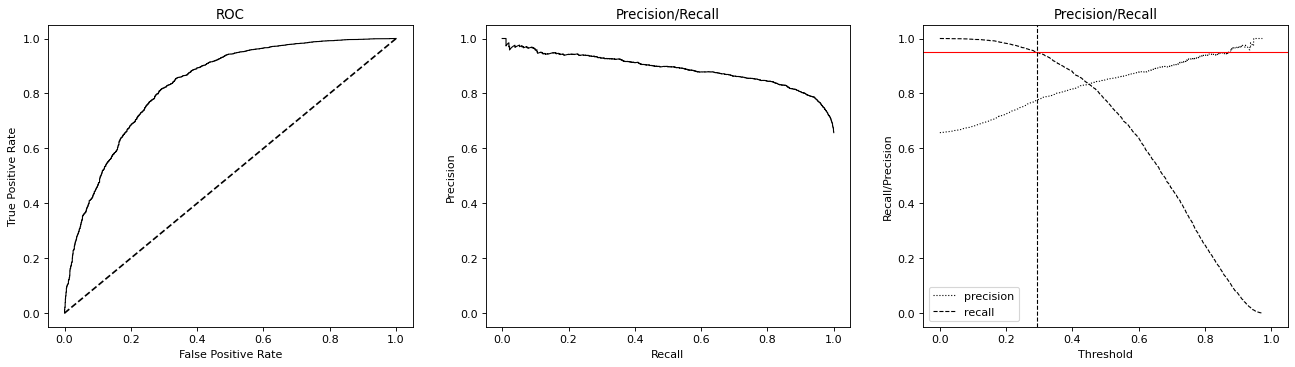

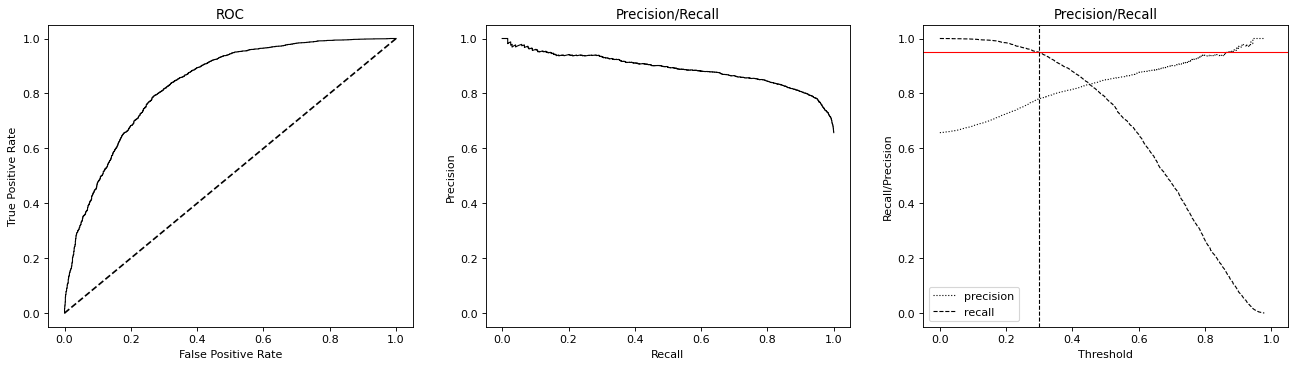

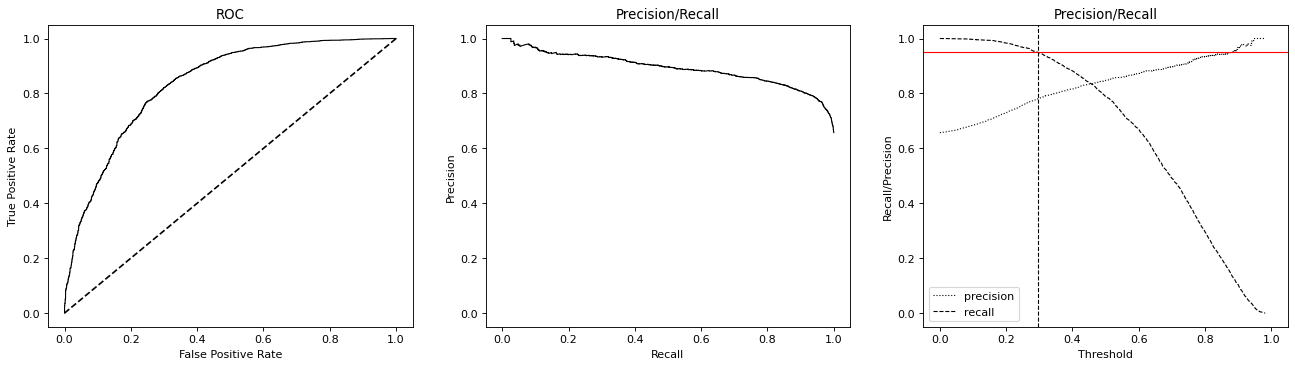

In [38]:
months = [i for i in range(1,9)]

performance_hist_passive = []

for month in tqdm(months):
    
    month_data = df_bags_train_std_miles_pca[invoice_months == month]
    month_labels = y_bag_train[invoice_months == month]
    
    # Pass all monthly data
    al_passive.teach(month_data, month_labels)
    
    # Predict on validation set
    y_bag_validation_pred = pd.DataFrame(al_passive.predict_proba(df_bags_validation_std_miles_pca))
    # Evaluate prediction
    min_threshold, specificity, auc = model_evaluation(y_bag_validation, y_bag_validation_pred)

    performance_hist_passive += [[min_threshold, specificity, auc]]

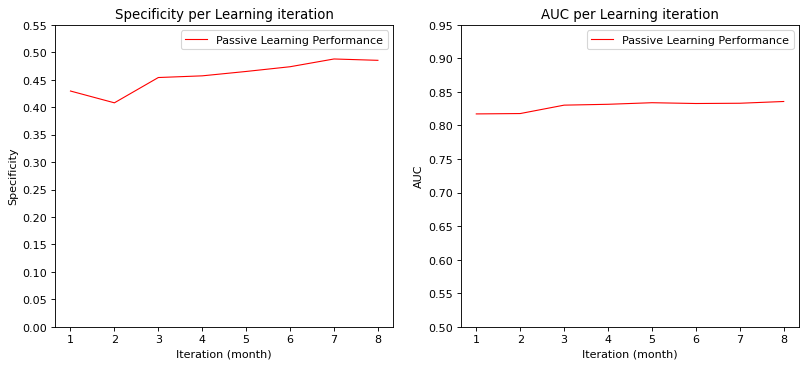

In [39]:
auc_evolution_passive = [i[2] for i in performance_hist_passive]
specificity_evolution_passive = [i[1]/100 for i in performance_hist_passive]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Learning iteration', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[0].legend()

axs[1].plot(np.arange(1, 9, 1), auc_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Learning iteration', yticks=np.arange(.5, 1, .05), xticks=np.arange(1, 9, 1))
axs[1].legend()

## Random

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

54


 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  3.50it/s]

AUC = 0.6834208228793299
Recall of 95.00 % reached on 0.556 threshold. This equals a 20.516 % specificity
54


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 25%|█████████████████████                                                               | 2/8 [00:00<00:02,  2.35it/s]

AUC = 0.7409003918135607
Recall of 95.00 % reached on 0.418 threshold. This equals a 26.843 % specificity
55


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [00:01<00:02,  1.69it/s]

AUC = 0.7595386960173888
Recall of 95.00 % reached on 0.443 threshold. This equals a 30.774 % specificity
73


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [00:03<00:03,  1.05it/s]

AUC = 0.7668746708317359
Recall of 95.00 % reached on 0.476 threshold. This equals a 28.256 % specificity
37


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:04<00:03,  1.26s/it]

AUC = 0.7737170408589825
Recall of 95.00 % reached on 0.428 threshold. This equals a 29.607 % specificity
65


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:07<00:03,  1.80s/it]

AUC = 0.7746810266034874
Recall of 95.00 % reached on 0.372 threshold. This equals a 32.432 % specificity
62


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:12<00:02,  2.72s/it]

AUC = 0.7730396135554738
Recall of 95.00 % reached on 0.440 threshold. This equals a 31.450 % specificity
49


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.22s/it]


AUC = 0.7939674331055299
Recall of 95.00 % reached on 0.414 threshold. This equals a 35.442 % specificity


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

108


 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  2.54it/s]

AUC = 0.7509982310527008
Recall of 95.00 % reached on 0.417 threshold. This equals a 28.747 % specificity
107


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 25%|█████████████████████                                                               | 2/8 [00:01<00:05,  1.10it/s]

AUC = 0.7663924811473674
Recall of 95.00 % reached on 0.309 threshold. This equals a 28.993 % specificity
110


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [00:03<00:07,  1.54s/it]

AUC = 0.7805909008248003
Recall of 95.00 % reached on 0.349 threshold. This equals a 34.521 % specificity
146


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [00:09<00:12,  3.05s/it]

AUC = 0.7897883246329258
Recall of 95.00 % reached on 0.352 threshold. This equals a 37.469 % specificity
73


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])


AUC = 0.7986226300869044
Recall of 95.00 % reached on 0.324 threshold. This equals a 38.514 % specificity


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:16<00:13,  4.38s/it]C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])


130


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:25<00:12,  6.25s/it]

AUC = 0.8110717836767181
Recall of 95.00 % reached on 0.349 threshold. This equals a 40.479 % specificity
125


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:37<00:08,  8.12s/it]

AUC = 0.8072670118488767
Recall of 95.00 % reached on 0.352 threshold. This equals a 42.752 % specificity
99


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:51<00:00,  6.40s/it]


AUC = 0.8120517112026243
Recall of 95.00 % reached on 0.344 threshold. This equals a 41.032 % specificity


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

216


 12%|██████████▌                                                                         | 1/8 [00:01<00:08,  1.18s/it]

AUC = 0.8046315008025997
Recall of 95.00 % reached on 0.600 threshold. This equals a 36.425 % specificity
215


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 25%|█████████████████████                                                               | 2/8 [00:05<00:18,  3.16s/it]

AUC = 0.8104173833907894
Recall of 95.00 % reached on 0.460 threshold. This equals a 40.541 % specificity
221


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [00:13<00:26,  5.38s/it]

AUC = 0.8161127324055872
Recall of 95.00 % reached on 0.403 threshold. This equals a 39.373 % specificity
291


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [00:28<00:36,  9.15s/it]

AUC = 0.8063939533019956
Recall of 95.00 % reached on 0.363 threshold. This equals a 39.988 % specificity
146


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Local\Temp\4\ipykernel_2248\2077724792.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:46<00:36, 12.15s/it]

AUC = 0.8191841822889563
Recall of 95.00 % reached on 0.362 threshold. This equals a 42.568 % specificity
261


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:11<00:33, 16.60s/it]

AUC = 0.81415110604473
Recall of 95.00 % reached on 0.346 threshold. This equals a 42.506 % specificity
250


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:45<00:22, 22.19s/it]

AUC = 0.8181932332845501
Recall of 95.00 % reached on 0.336 threshold. This equals a 44.410 % specificity
197


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:23<00:00, 17.93s/it]

AUC = 0.8226421711682845
Recall of 95.00 % reached on 0.330 threshold. This equals a 45.086 % specificity


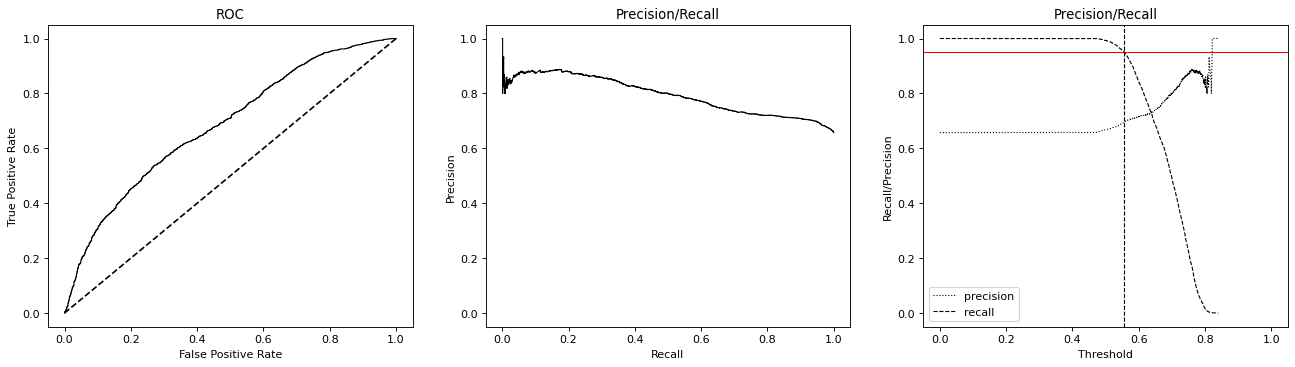

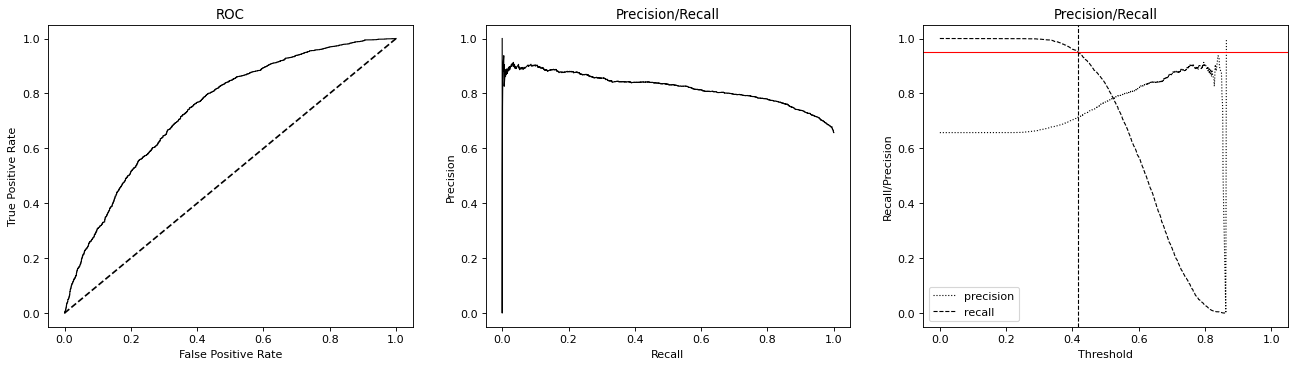

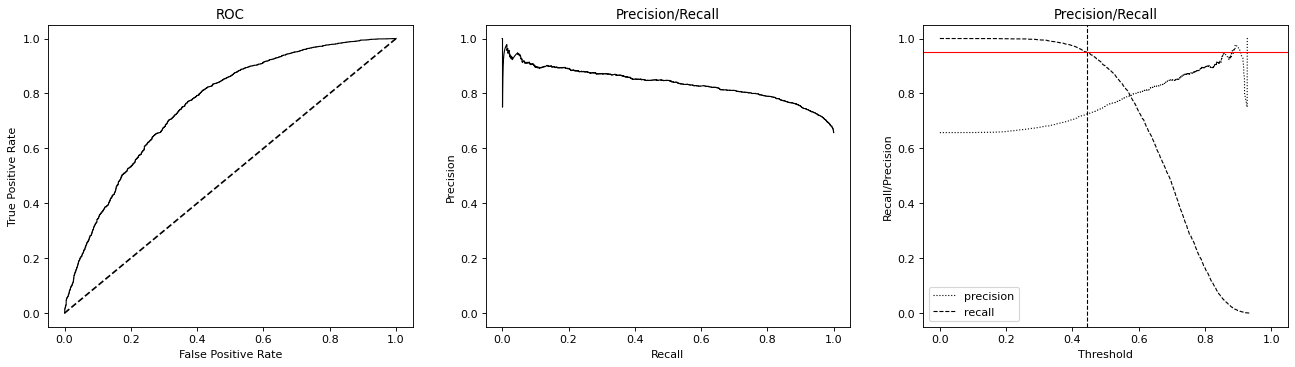

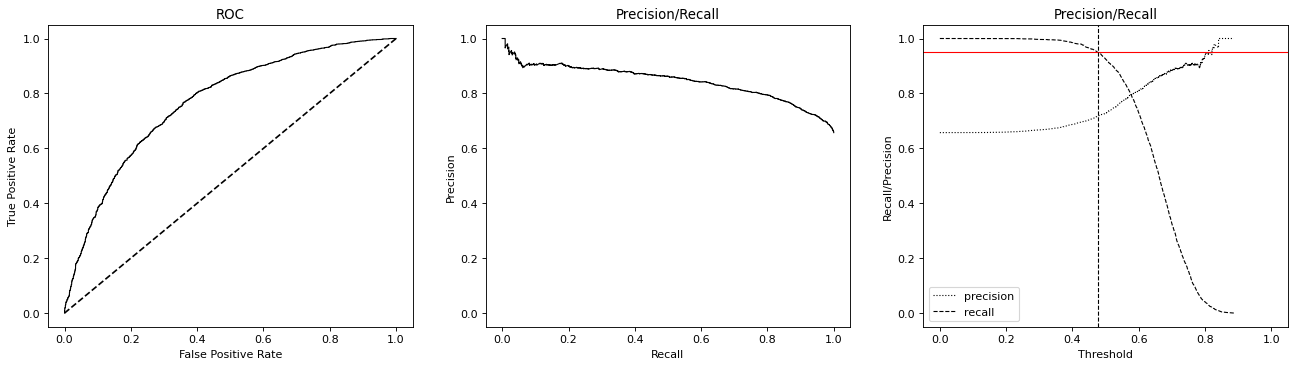

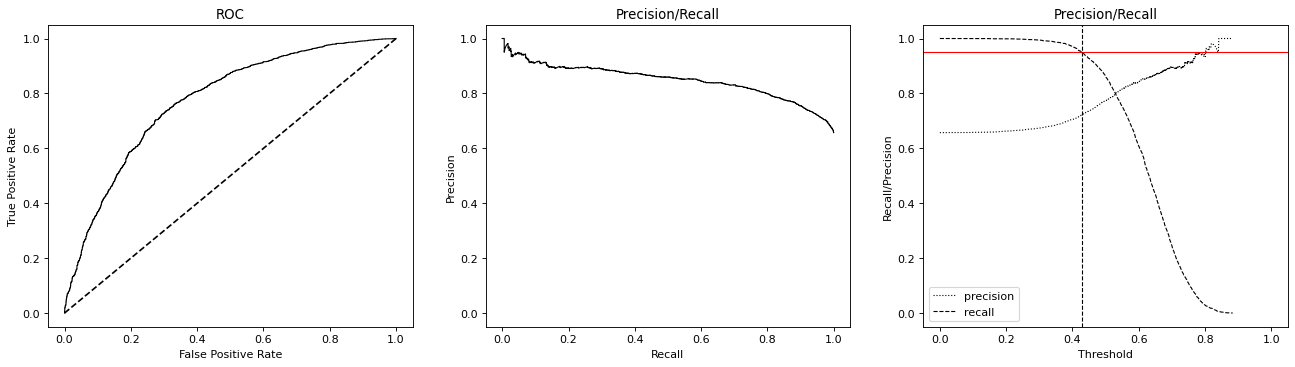

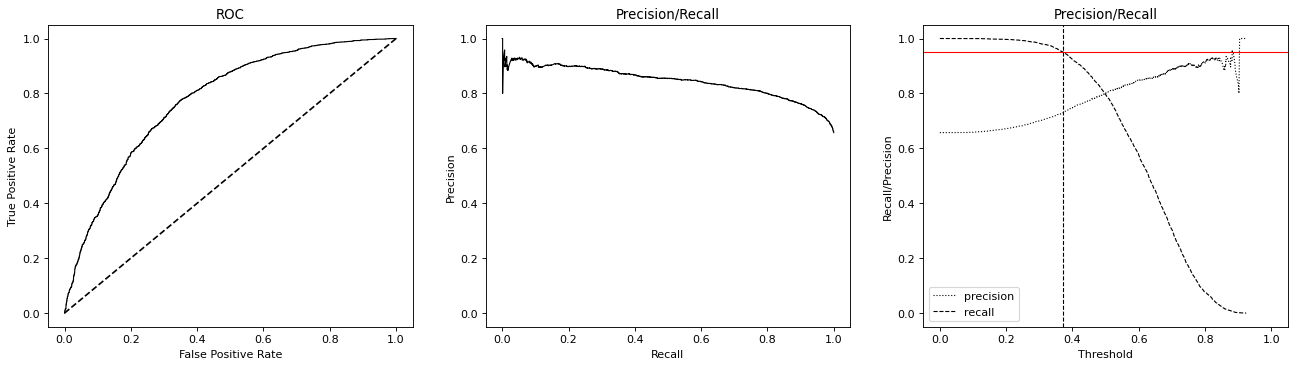

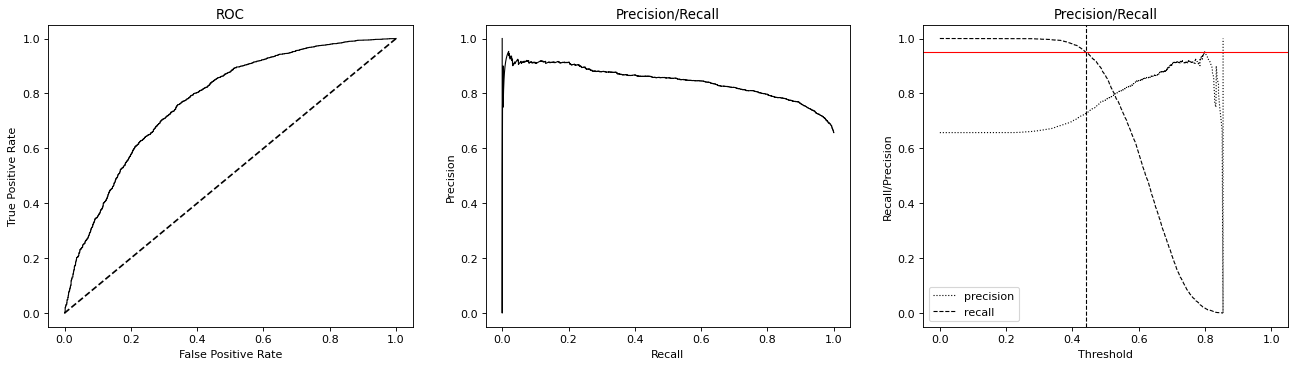

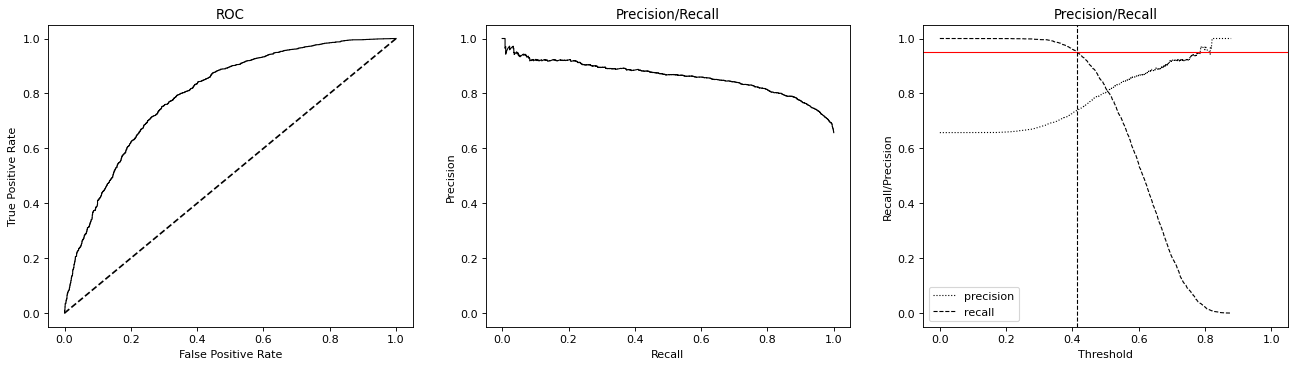

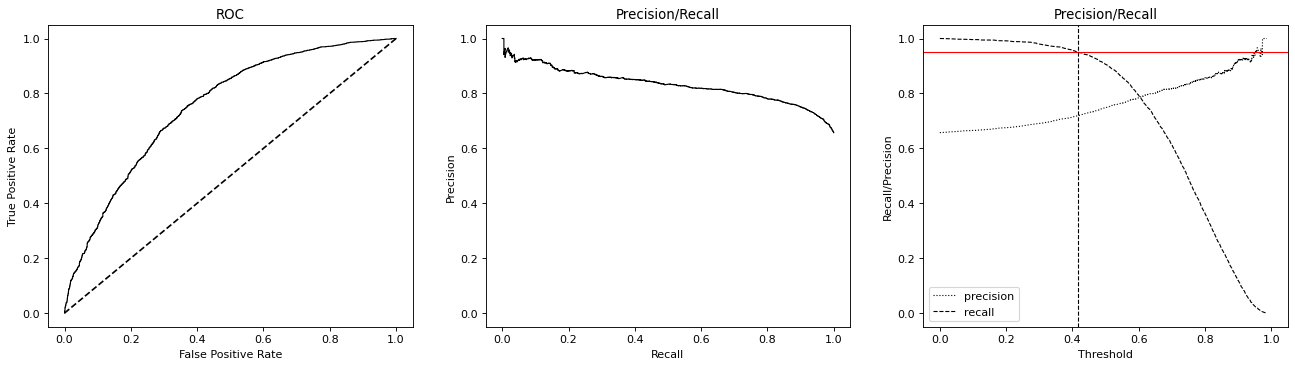

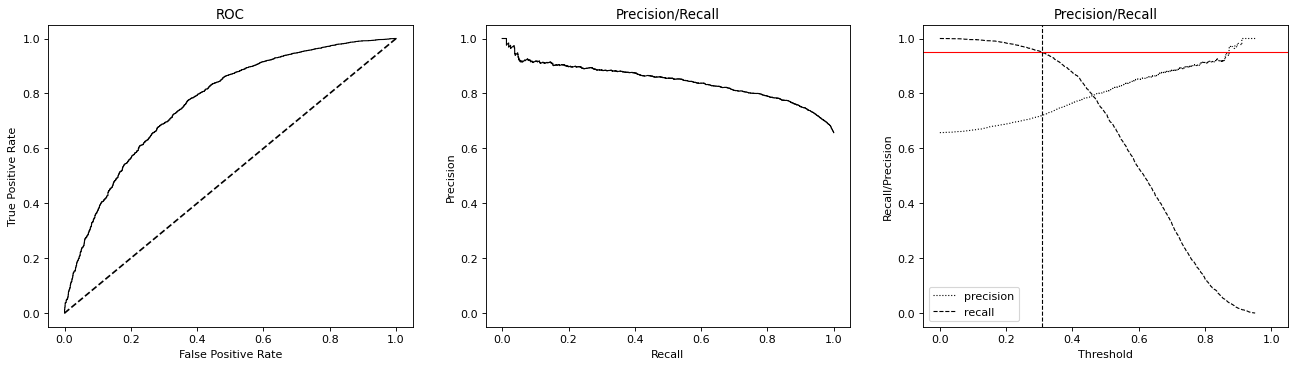

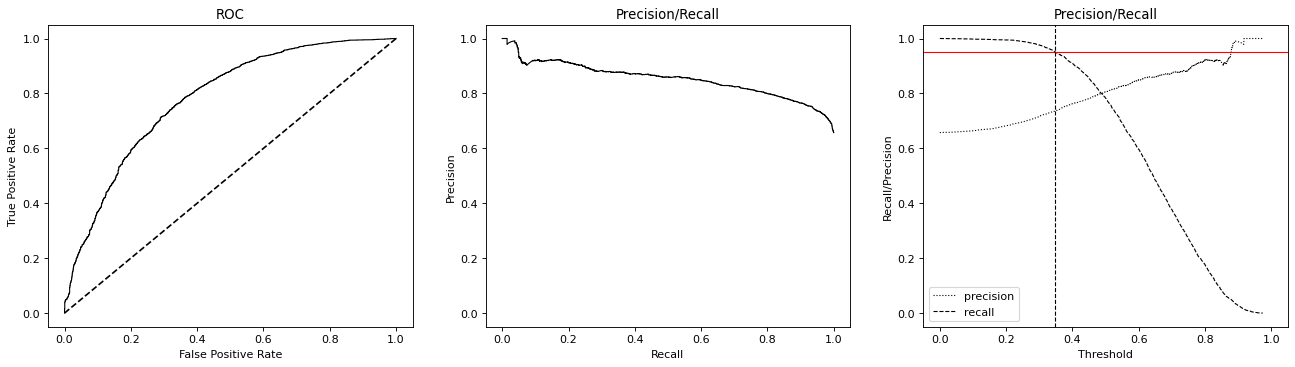

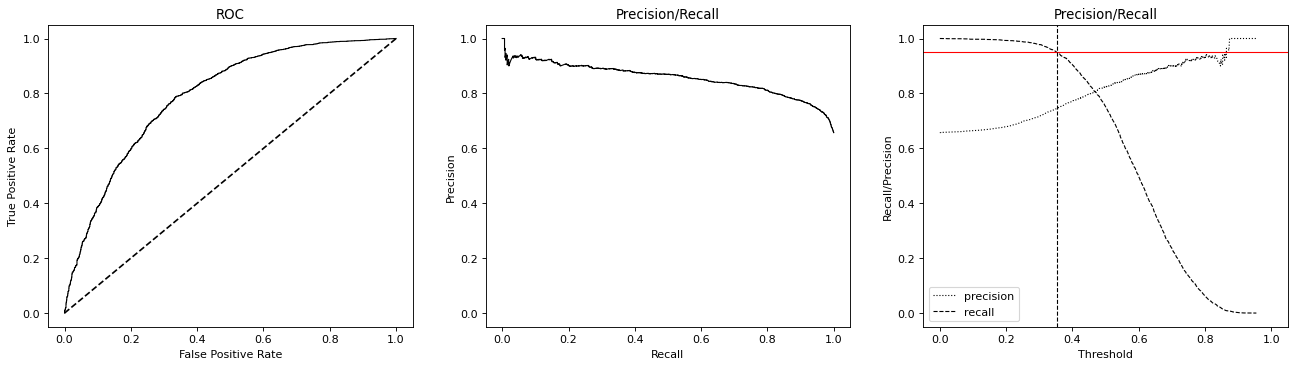

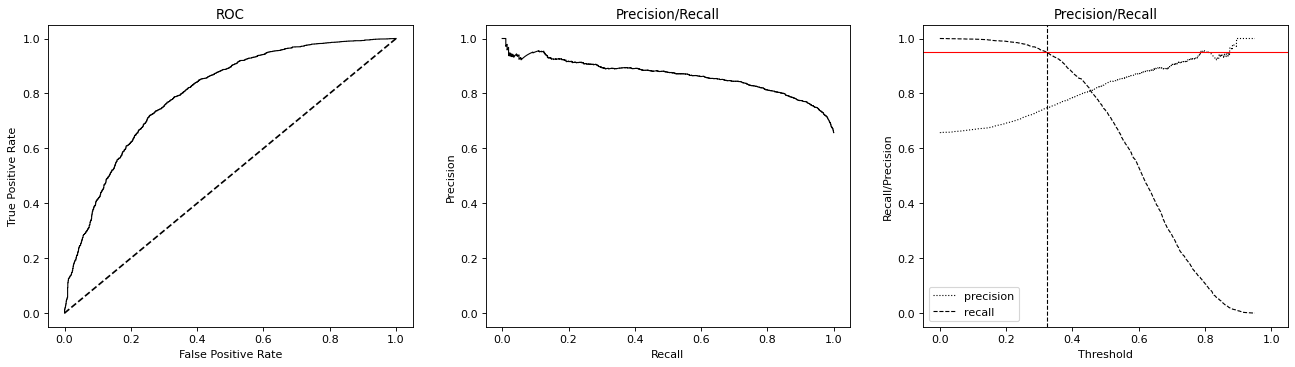

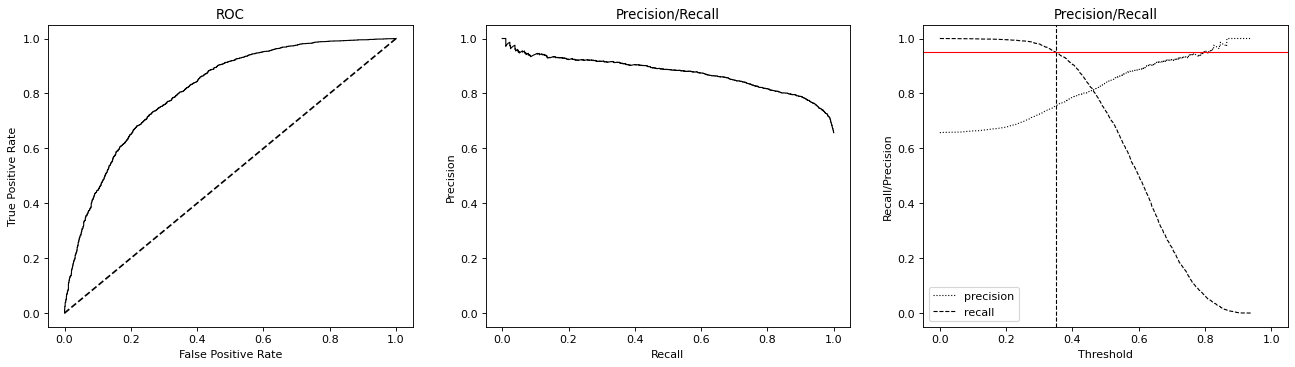

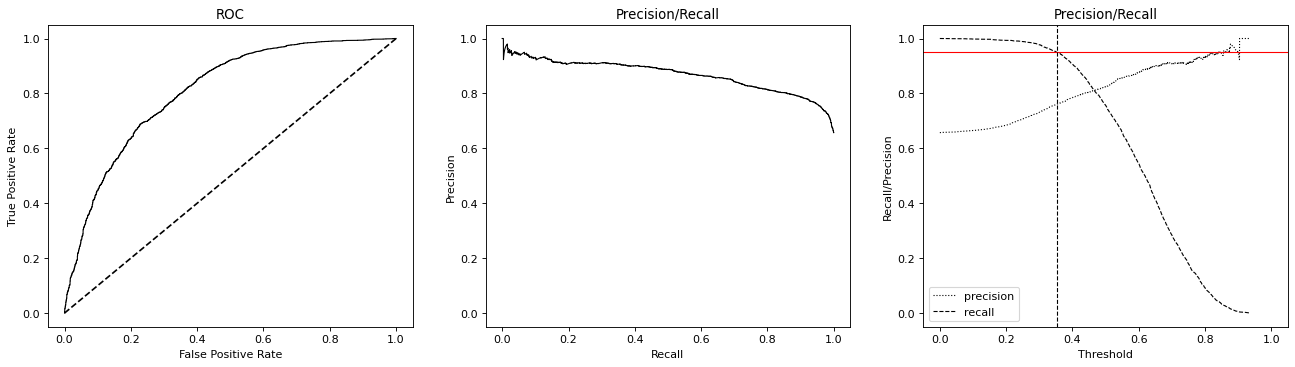

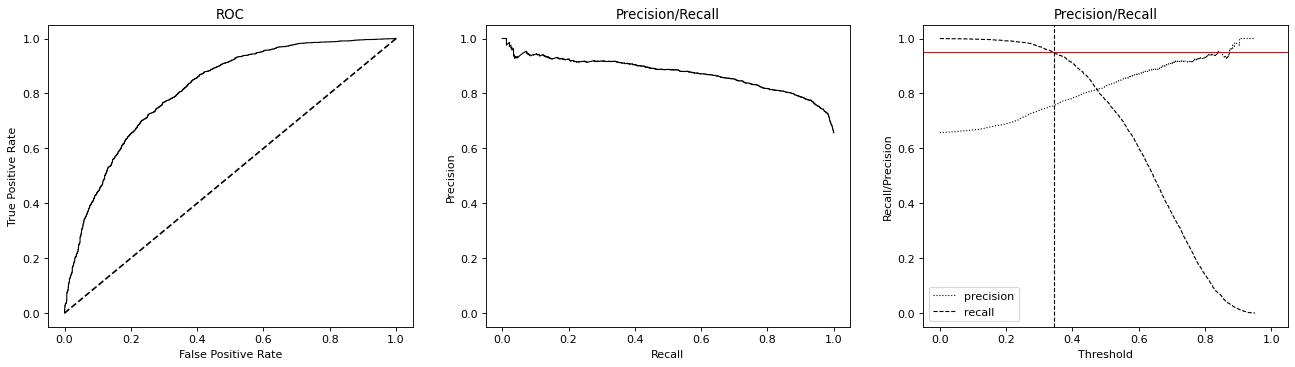

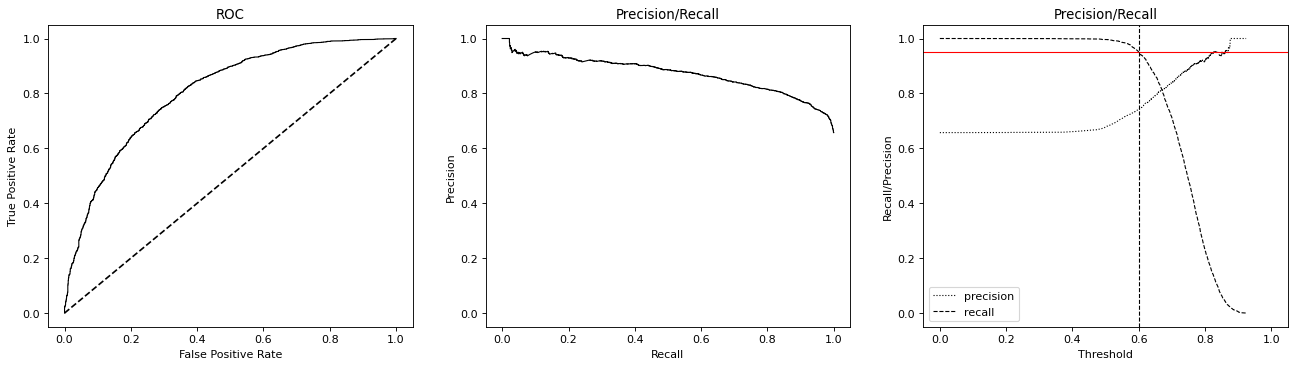

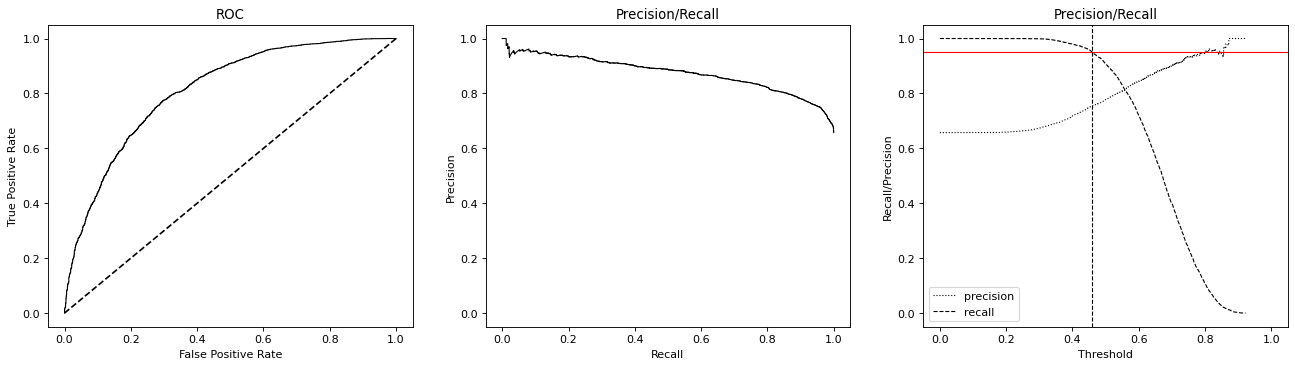

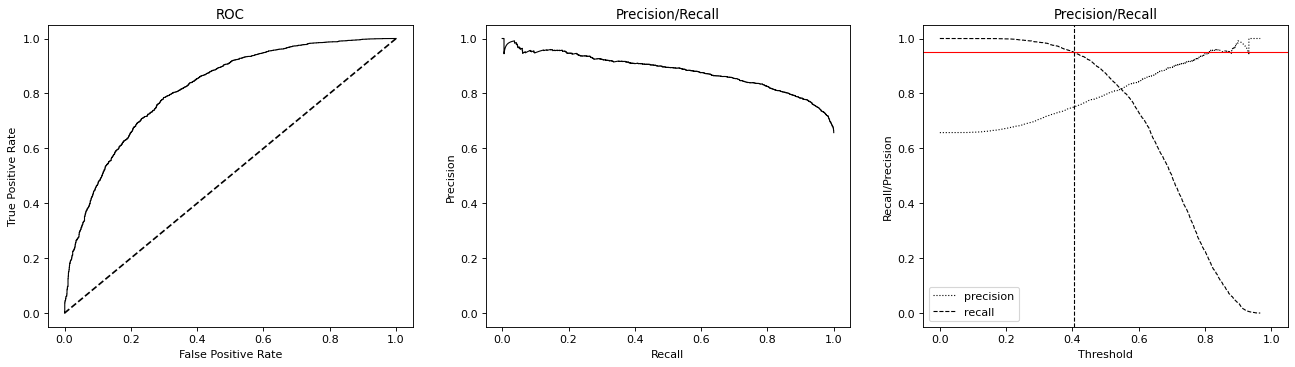

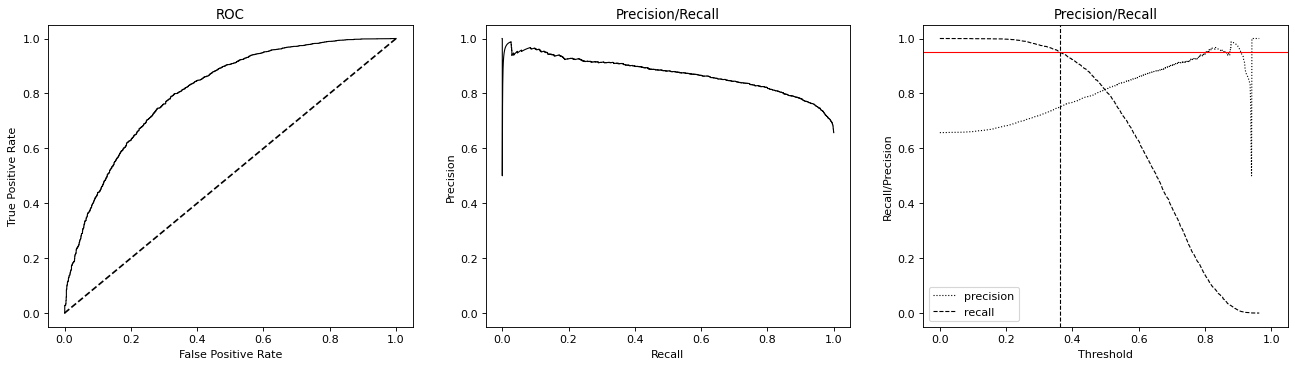

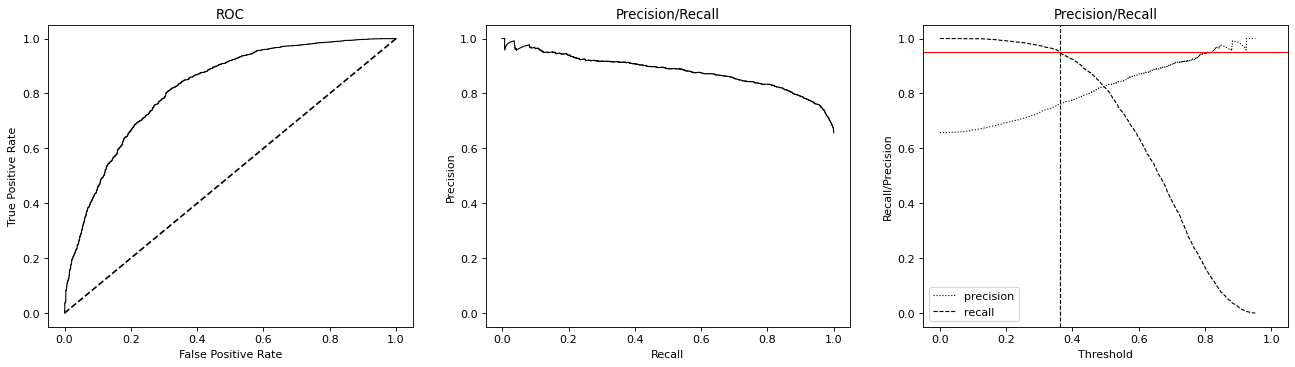

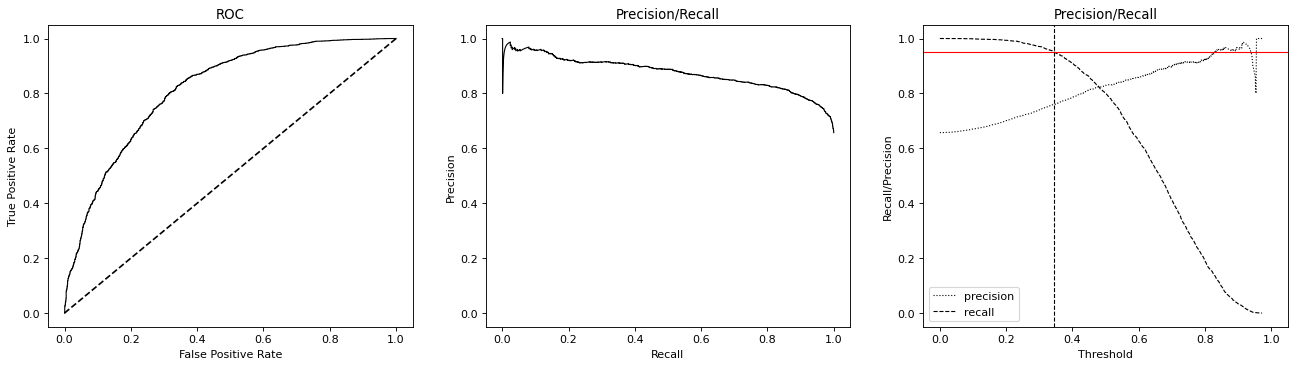

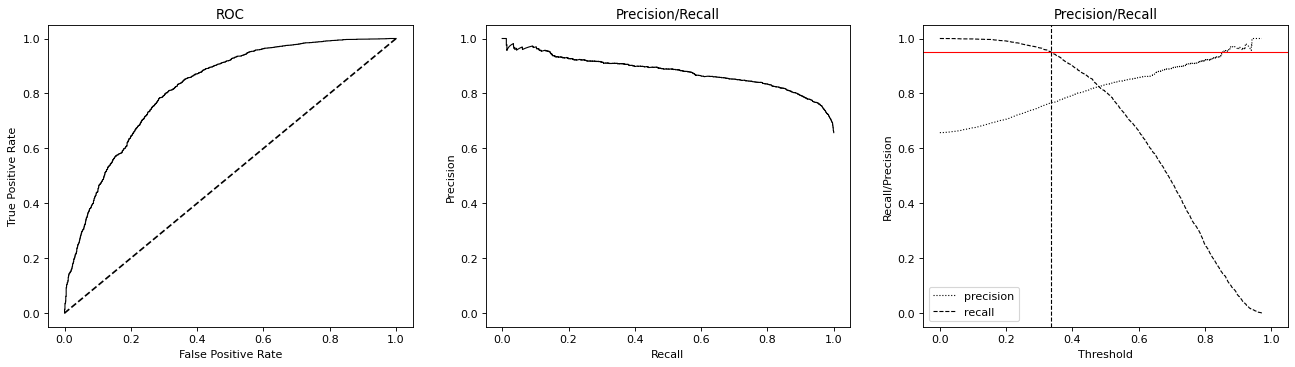

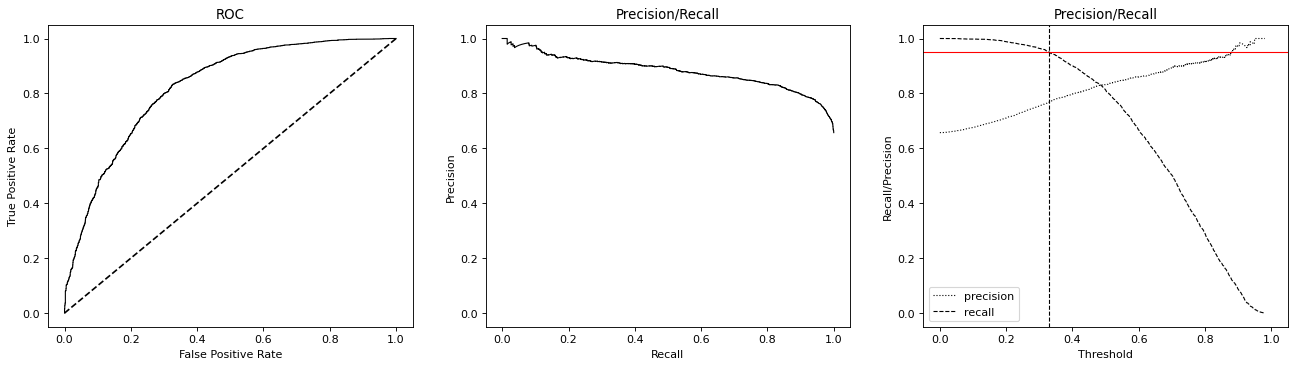

In [68]:
months = [i for i in range(1,9)]

queried_invoice_per_month = [(0.05, 'dotted'), (0.10, 'dashed'), (0.20, 'solid')]

performance_hist_random = []

for qinv in queried_invoice_per_month:

    performance_hist_random_ = []

    # Fit model
    al_random = ActiveLearner(
        estimator=BaggingClassifier(SVC(C=0.1, kernel='linear', probability=True), n_estimators=15),
        X_training=None, 
        y_training=None
    )
    
    for month in tqdm(months):

        month_data = df_bags_train_std_miles_pca[invoice_months == month].reset_index(drop=True)
        month_labels = y_bag_train[invoice_months == month]

        random_idx = np.random.choice([i for i in range(month_data.shape[0])], int(round(month_data.shape[0]*qinv[0], 0)), replace=False)
        print(len(random_idx))
        
        al_random.teach(month_data[month_data.index.isin(random_idx)], month_labels[pd.Series(month_labels).index.isin(random_idx)])

        # Predict on validation set
        y_bag_validation_pred = pd.DataFrame(al_random.predict_proba(df_bags_validation_std_miles_pca))
        # Evaluate prediction
        min_threshold, specificity, auc = model_evaluation(y_bag_validation, y_bag_validation_pred)

        performance_hist_random_ += [[min_threshold, specificity, auc]]
    
    performance_hist_random += [(qinv, performance_hist_random_)]

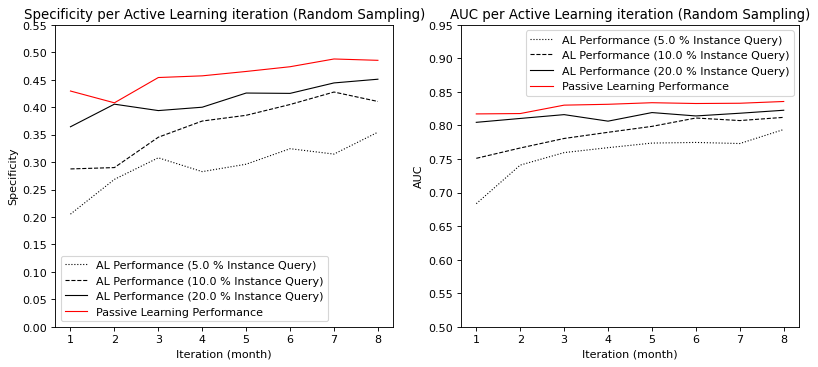

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

for qry in performance_hist_random:
    
    axs[0].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls=qry[0][1], label='AL Performance ({} % Instance Query)'.format(qry[0][0]*100))

    axs[1].plot(np.arange(1, 9, 1), [i[2] for i in qry[1]], lw=1, color='black', ls=qry[0][1], label='AL Performance ({} % Instance Query)'.format(qry[0][0]*100))

    
axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (Random Sampling)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[0].legend()

axs[1].plot(np.arange(1, 9, 1), auc_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Active Learning iteration (Random Sampling)', yticks=np.arange(.5, 1, .05), xticks=np.arange(1, 9, 1))
axs[1].legend()

### Passive-Random Upper & Lower bound plots

In [72]:
if True:
    warnings.warn('Fixed Passive & Random learning results')
    specificity_evolution_passive = [0.42076167076167076, 0.4244471744471745, 0.4465601965601966, 0.4441031941031941, 0.46498771498771496, 0.47174447174447176, 0.4705159705159705, 0.4803439803439804]
    performance_hist_random = [((0.05, 'dotted'),
                  [[0.6498692943904971, 13.697788697788699, 0.6417202717266799],[0.5077214478958157, 20.638820638820636, 0.6838378677532795],[0.4879288909856631, 25.184275184275183, 0.7480749806927314],[0.4727988987827199, 25.73710073710074, 0.7549132176655406],
                   [0.45378792738563306, 29.79115479115479, 0.766380081984055],[0.4307462562922532, 34.64373464373464, 0.7846558582700847],[0.3912490484335158, 34.45945945945946, 0.7790221114476161],[0.38048967984899934, 36.79361179361179, 0.792699766265931]]),
                 ((0.1, 'dashed'),
                  [[0.5459848653892412, 31.941031941031937, 0.7684826258200177],[0.4449859075974761, 28.746928746928745, 0.7528447223256579],[0.47141545378514693, 34.15233415233415, 0.7829380821210363],[0.42738461620562046, 38.39066339066339, 0.7999642982821451],
                   [0.4018545748188484, 39.434889434889435, 0.8076147788579702],[0.38066095552042306, 39.80343980343981, 0.8101166544774363],[0.35136405944216575, 40.72481572481573, 0.8156516016176381],[0.3510595490818863, 42.69041769041769, 0.8217163669742971]]),
                 ((0.2, 'solid'),
                  [[0.4762643758501752, 28.869778869778866, 0.7646363266356858],[0.3541579226675619, 30.0982800982801, 0.7797558270163205],[0.38590965556878465, 39.250614250614255, 0.8082345402114708],[0.3514733920766675, 40.54054054054054, 0.8099605824693937],
                   [0.3439445737774953, 42.69041769041769, 0.817886600007715],[0.32748786322944207, 44.041769041769044, 0.8245049978468754],[0.3343337620968258, 45.94594594594595, 0.8269344466076283],[0.31954078912952183, 46.19164619164619, 0.8294221517547375]])]

C:\Users\Ward\AppData\Local\Temp\4\ipykernel_2248\3166585048.py:2: UserWarning: Fixed Passive & Random learning results
  warnings.warn('Fixed Passive & Random learning results')


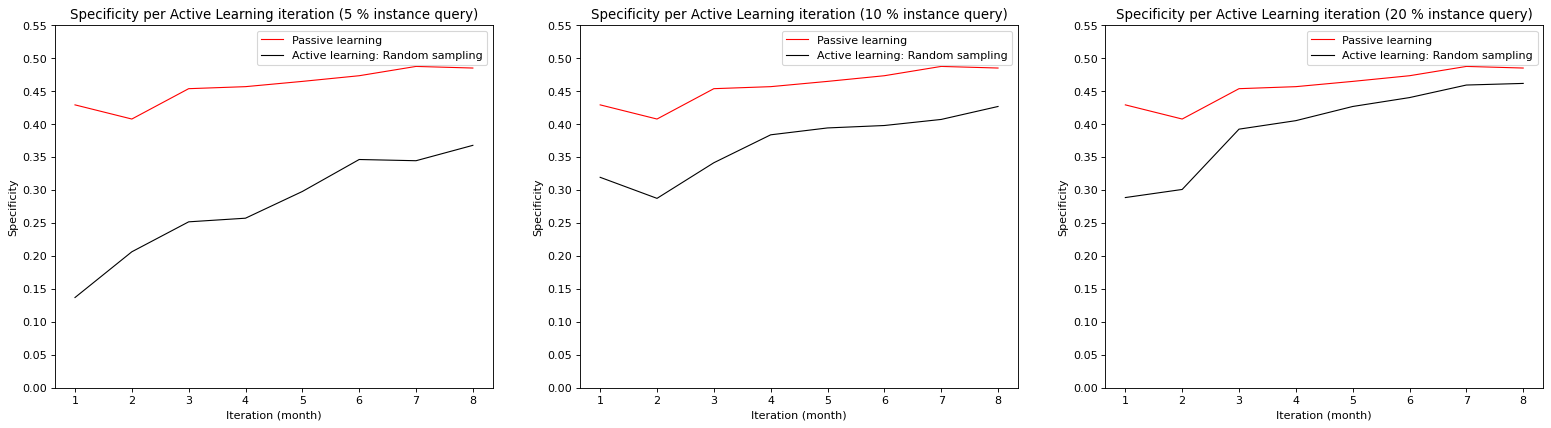

In [79]:
auc_evolution_passive = [i[2] for i in performance_hist_passive]
specificity_evolution_passive = [i[1]/100 for i in performance_hist_passive]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), dpi=80)

axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[1].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[2].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[0].plot(np.arange(1, 9, 1), [i[1]/100 for i in performance_hist_random[0][1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')
axs[1].plot(np.arange(1, 9, 1), [i[1]/100 for i in performance_hist_random[1][1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')
axs[2].plot(np.arange(1, 9, 1), [i[1]/100 for i in performance_hist_random[2][1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (5 % instance query)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[0].legend()
axs[1].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (10 % instance query)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[1].legend()
axs[2].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (20 % instance query)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[2].legend()


In [ ]:


sample_size_idx = 0

# Upper bound
axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[1].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[2].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')


for idx in [0, 1, 2]:

    # Uncertainty
    qry = performance_hist_uncertainty[idx]
    axs[idx].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dotted', label='Active learning: Uncertainty sampling')

    # Lower bound
    qry = performance_hist_random[idx]
    axs[idx].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

    axs[idx].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration ({:.0f} % instance query)'.format(performance_hist_uncertainty[idx][0][0]*100), yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
    axs[idx].legend()

In [44]:
# LaTeX
print('& '.join([str(round(i, 3)) for i in specificity_evolution_passive]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_random[0][1]]]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_random[1][1]]]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_random[2][1]]]))

0.429& 0.408& 0.454& 0.457& 0.465& 0.474& 0.488& 0.485
0.137& 0.206& 0.252& 0.257& 0.298& 0.346& 0.345& 0.368
0.319& 0.287& 0.342& 0.384& 0.394& 0.398& 0.407& 0.427
0.289& 0.301& 0.393& 0.405& 0.427& 0.44& 0.459& 0.462


## Uncertainty Sampling

In [45]:
from modAL.uncertainty import uncertainty_sampling


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

AUC = 0.5017484788391549
Recall of 95.00 % reached on 0.668 threshold. This equals a 6.143 % specificity


 12%|██████████▌                                                                         | 1/8 [00:00<00:03,  1.85it/s]C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 25%|█████████████████████                                                               | 2/8 [00:00<00:02,  2.11it/s]

AUC = 0.6720086723290825
Recall of 95.00 % reached on 0.438 threshold. This equals a 15.049 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [00:01<00:03,  1.56it/s]

AUC = 0.7316584884672036
Recall of 95.00 % reached on 0.407 threshold. This equals a 23.771 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [00:03<00:03,  1.03it/s]

AUC = 0.7429427111420062
Recall of 95.00 % reached on 0.336 threshold. This equals a 28.931 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:04<00:03,  1.20s/it]

AUC = 0.7677048243373139
Recall of 95.00 % reached on 0.311 threshold. This equals a 33.415 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:07<00:03,  1.76s/it]

AUC = 0.7728237106641465
Recall of 95.00 % reached on 0.303 threshold. This equals a 33.968 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:11<00:02,  2.40s/it]

AUC = 0.7882461048914109
Recall of 95.00 % reached on 0.335 threshold. This equals a 36.671 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.98s/it]


AUC = 0.7935206696020537
Recall of 95.00 % reached on 0.287 threshold. This equals a 38.698 % specificity


 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  2.90it/s]

AUC = 0.6003822484918288
Recall of 95.00 % reached on 0.562 threshold. This equals a 15.111 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 25%|█████████████████████                                                               | 2/8 [00:01<00:03,  1.52it/s]

AUC = 0.7264726860209079
Recall of 95.00 % reached on 0.480 threshold. This equals a 27.580 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [00:03<00:06,  1.35s/it]

AUC = 0.7664074388681887
Recall of 95.00 % reached on 0.392 threshold. This equals a 30.467 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [00:08<00:11,  2.79s/it]

AUC = 0.7865017591066934
Recall of 95.00 % reached on 0.357 threshold. This equals a 37.654 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:14<00:12,  4.02s/it]

AUC = 0.803785208703504
Recall of 95.00 % reached on 0.351 threshold. This equals a 39.312 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:23<00:11,  5.78s/it]

AUC = 0.8077960428168695
Recall of 95.00 % reached on 0.333 threshold. This equals a 39.988 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:34<00:07,  7.50s/it]

AUC = 0.8148078680760514
Recall of 95.00 % reached on 0.349 threshold. This equals a 45.086 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:48<00:00,  6.02s/it]


AUC = 0.822649256404463
Recall of 95.00 % reached on 0.348 threshold. This equals a 44.349 % specificity


 12%|██████████▌                                                                         | 1/8 [00:00<00:05,  1.29it/s]

AUC = 0.6994741967507107
Recall of 95.00 % reached on 0.551 threshold. This equals a 24.754 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 25%|█████████████████████                                                               | 2/8 [00:04<00:15,  2.52s/it]

AUC = 0.7733084589060237
Recall of 95.00 % reached on 0.432 threshold. This equals a 34.214 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 38%|███████████████████████████████▌                                                    | 3/8 [00:12<00:24,  4.93s/it]

AUC = 0.7900563827350114
Recall of 95.00 % reached on 0.400 threshold. This equals a 40.356 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 50%|██████████████████████████████████████████                                          | 4/8 [00:26<00:33,  8.43s/it]

AUC = 0.8074055675785892
Recall of 95.00 % reached on 0.339 threshold. This equals a 41.523 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Local\Temp\4\ipykernel_2248\2077724792.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=80)
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:44<00:35, 11.90s/it]

AUC = 0.817628776135665
Recall of 95.00 % reached on 0.341 threshold. This equals a 44.410 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:09<00:32, 16.32s/it]

AUC = 0.8234061958028636
Recall of 95.00 % reached on 0.335 threshold. This equals a 46.560 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:39<00:20, 20.98s/it]

AUC = 0.8245266471796431
Recall of 95.00 % reached on 0.332 threshold. This equals a 46.314 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:18<00:00, 17.31s/it]

AUC = 0.8289692870756633
Recall of 95.00 % reached on 0.344 threshold. This equals a 46.437 % specificity


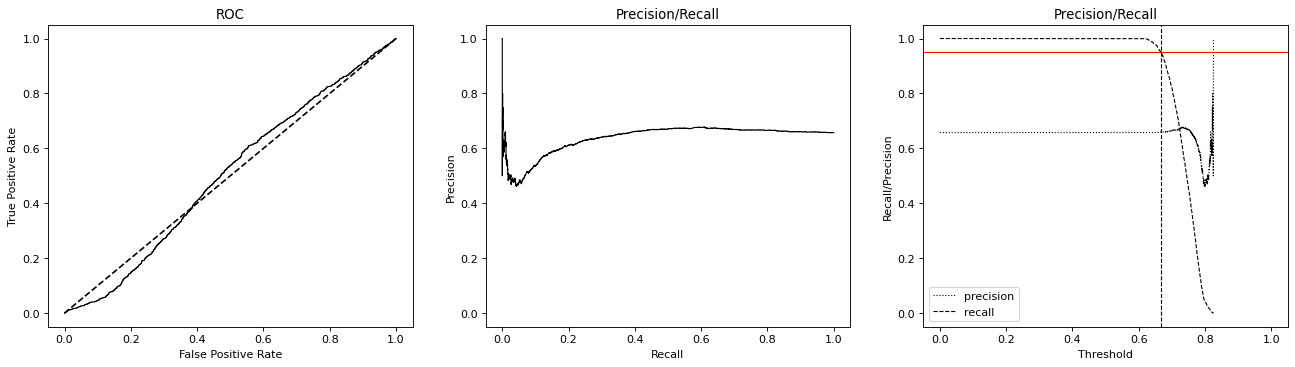

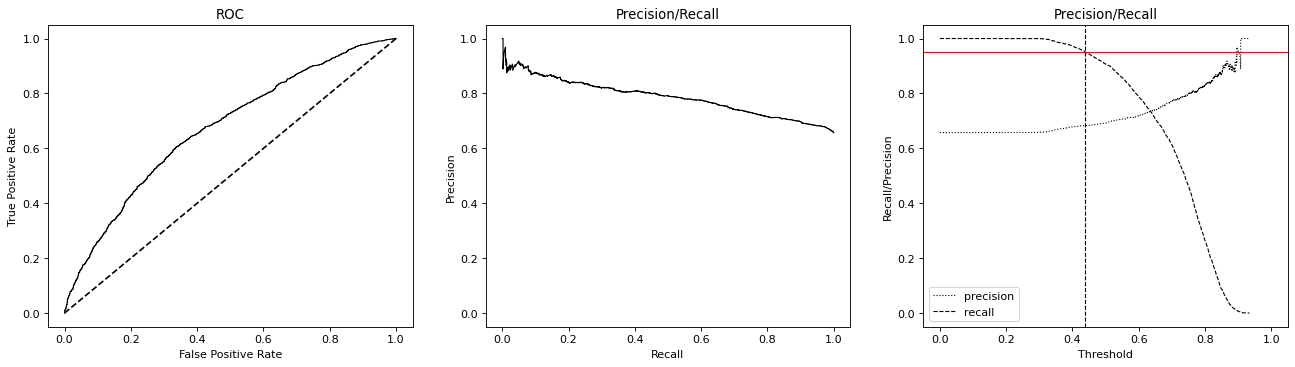

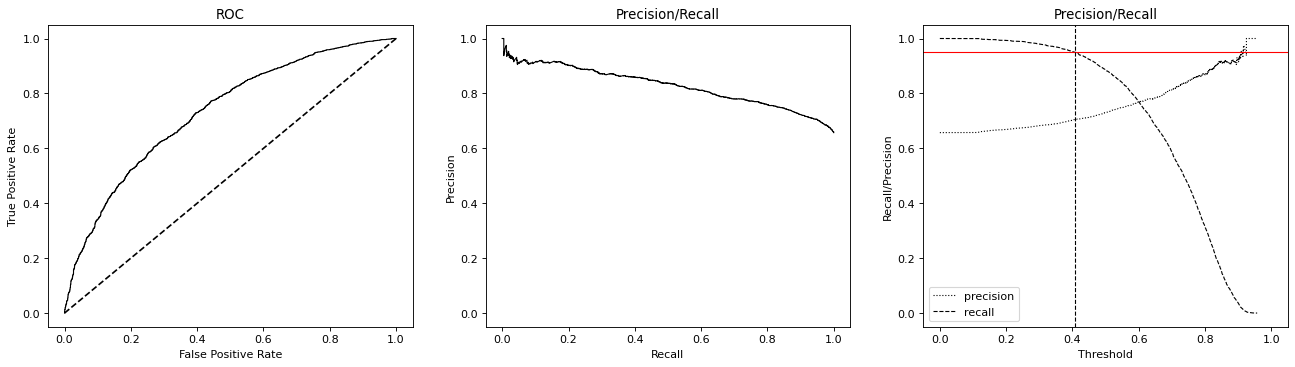

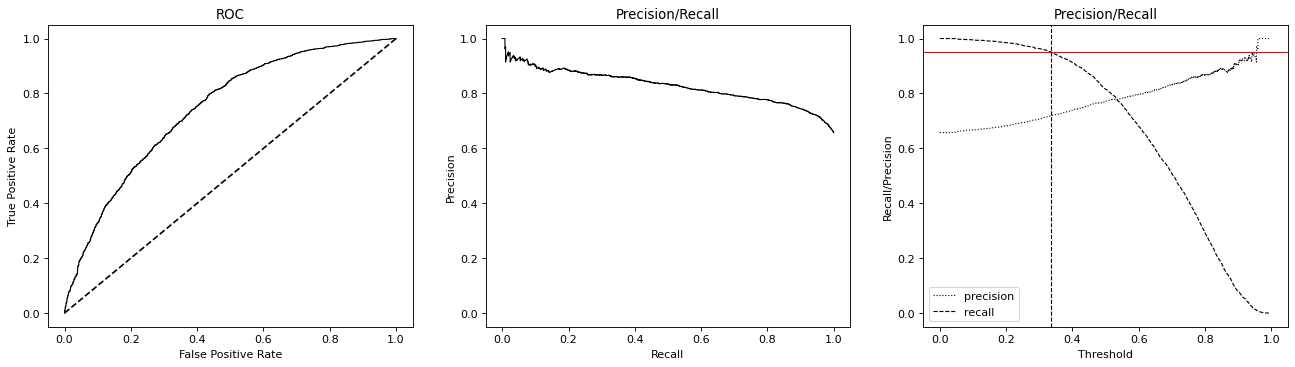

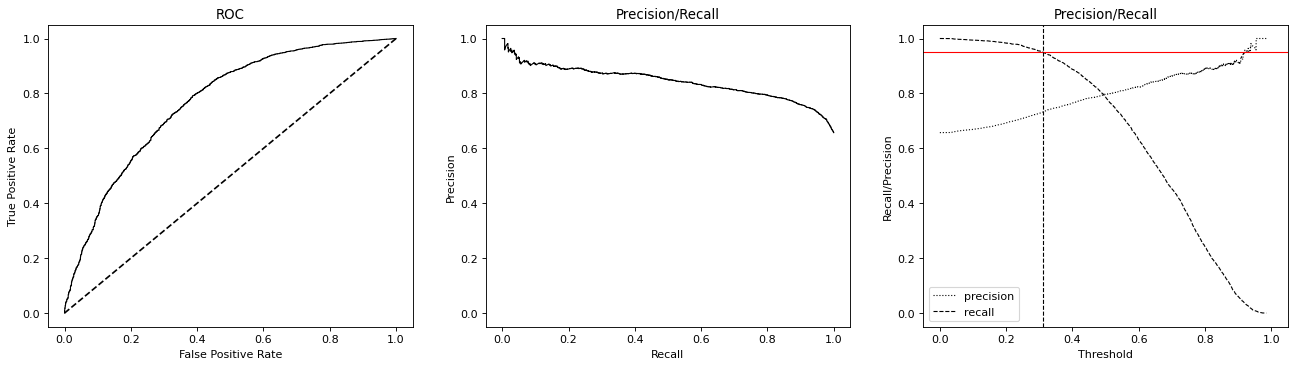

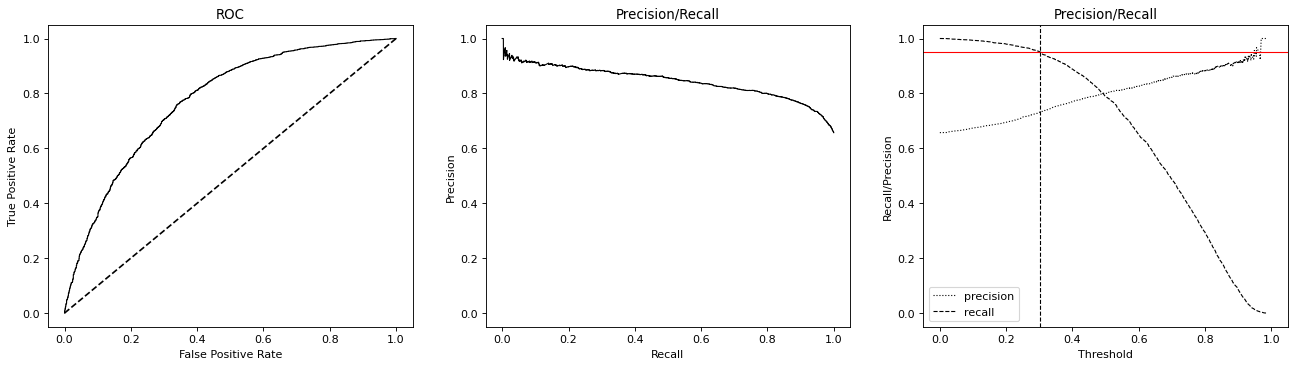

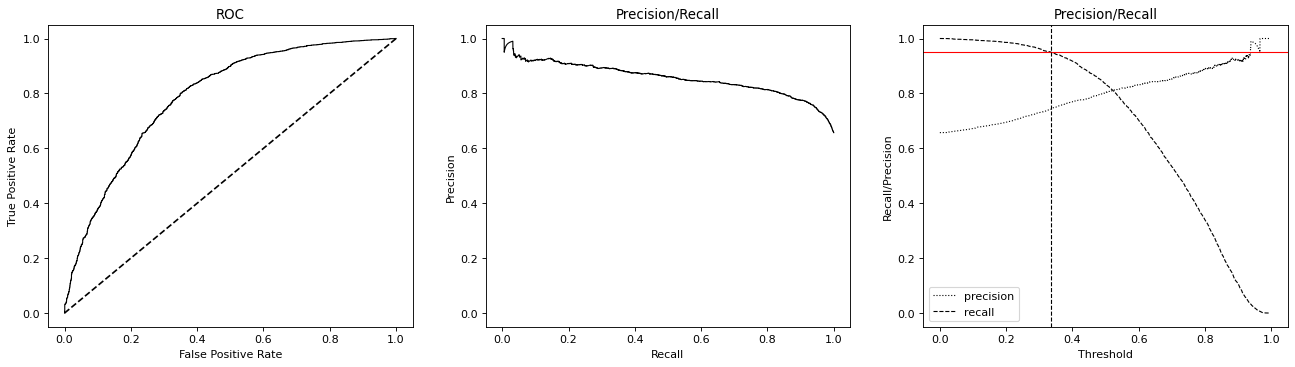

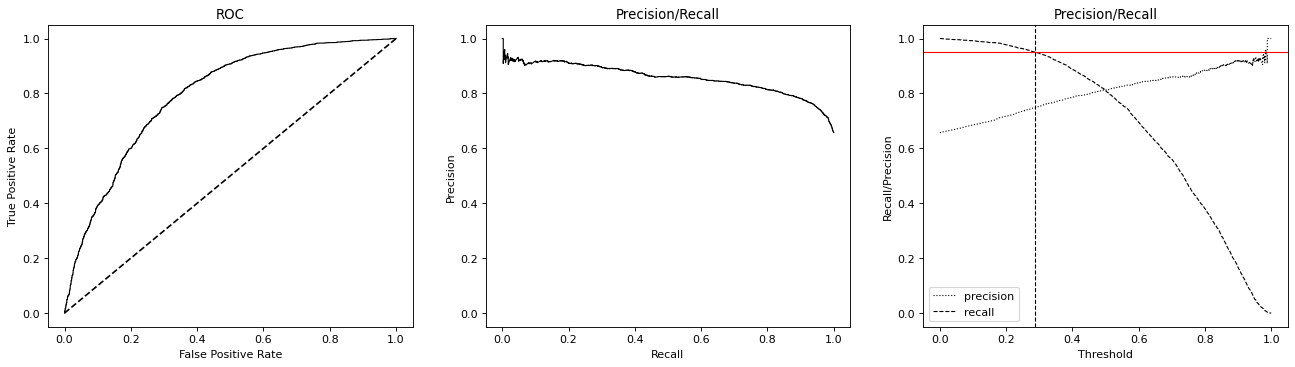

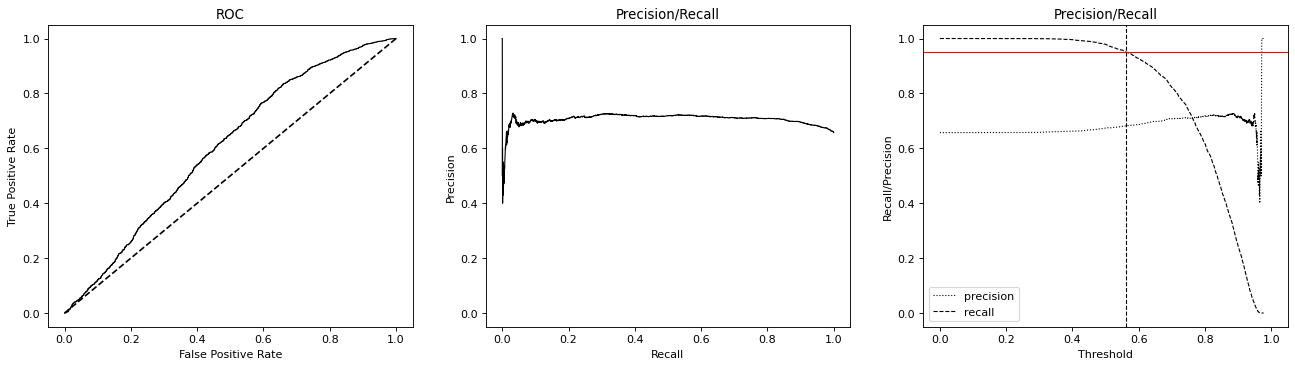

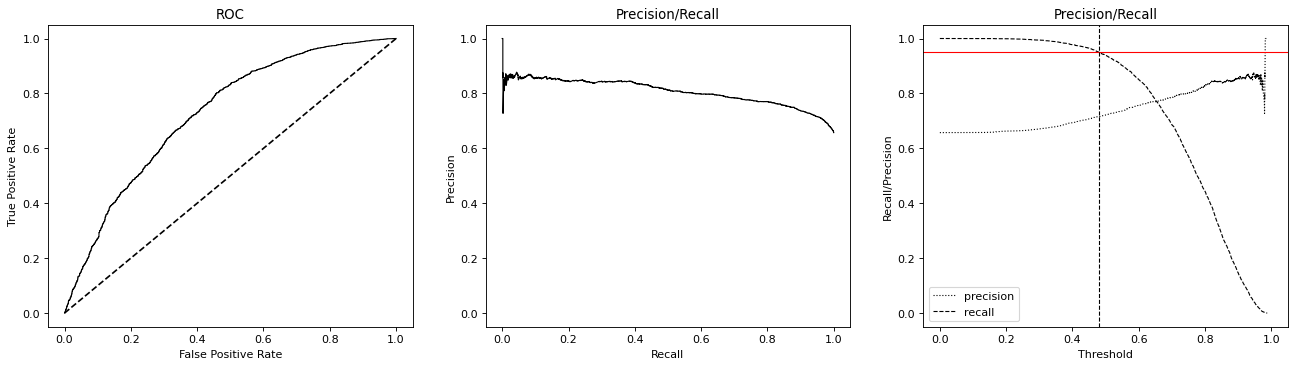

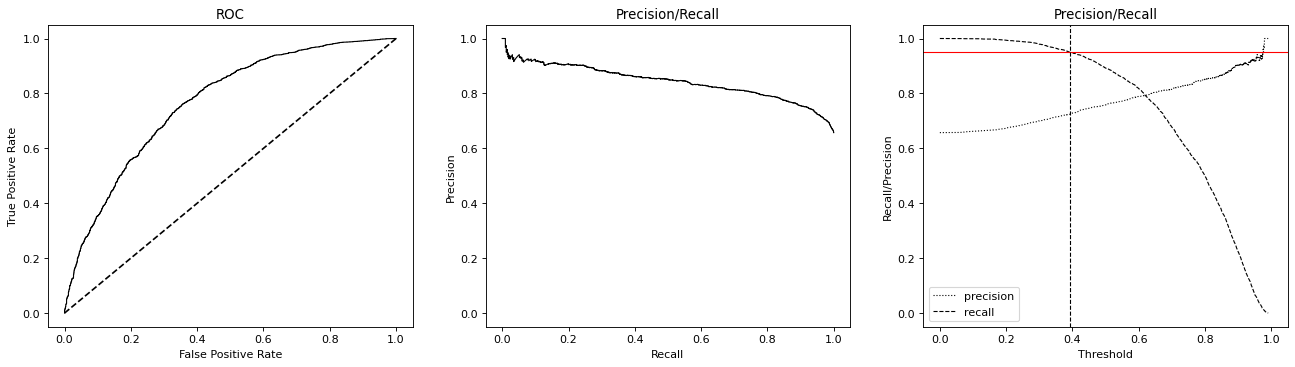

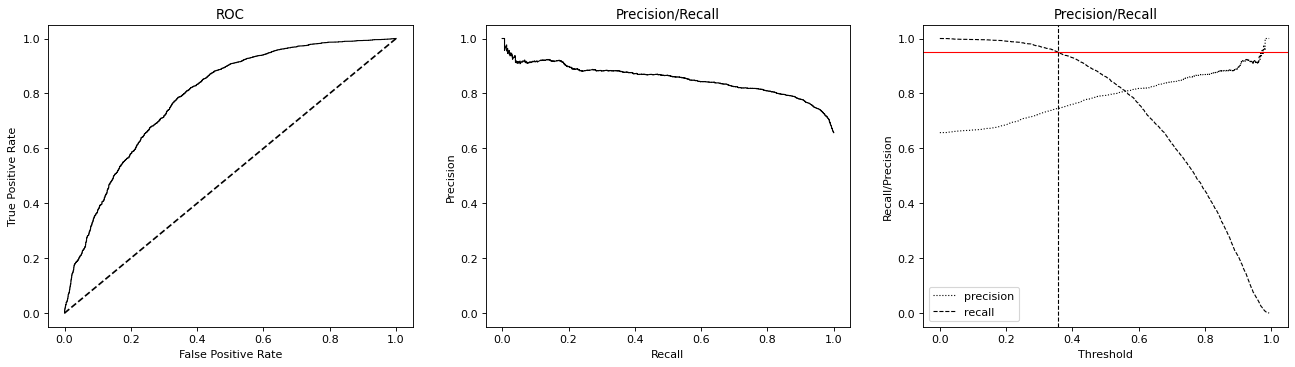

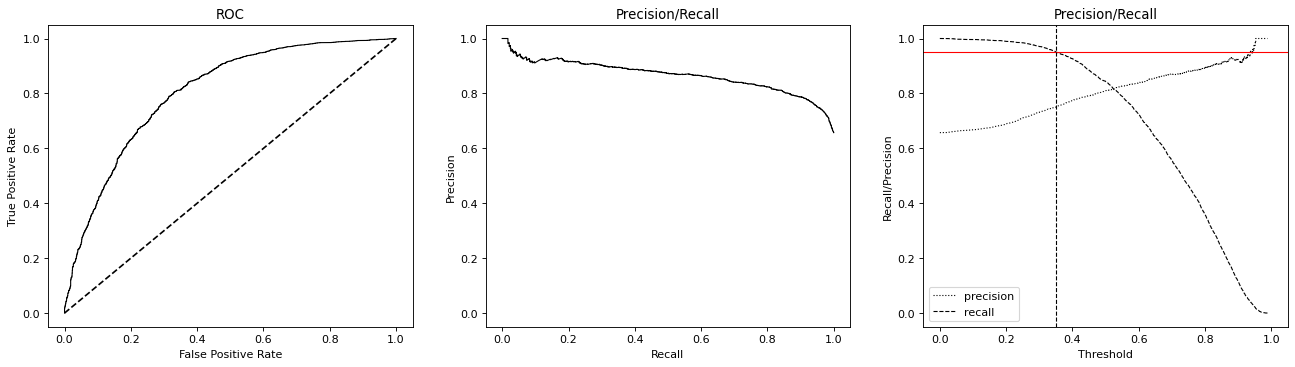

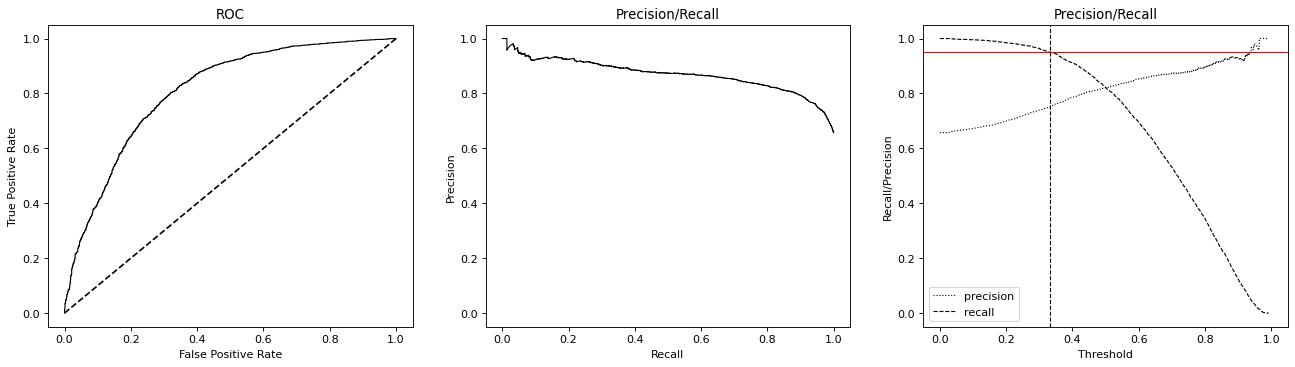

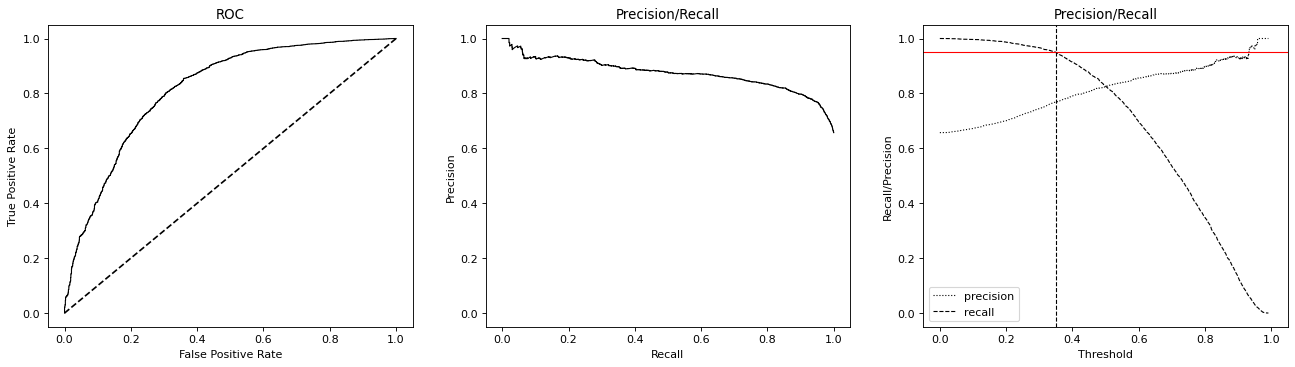

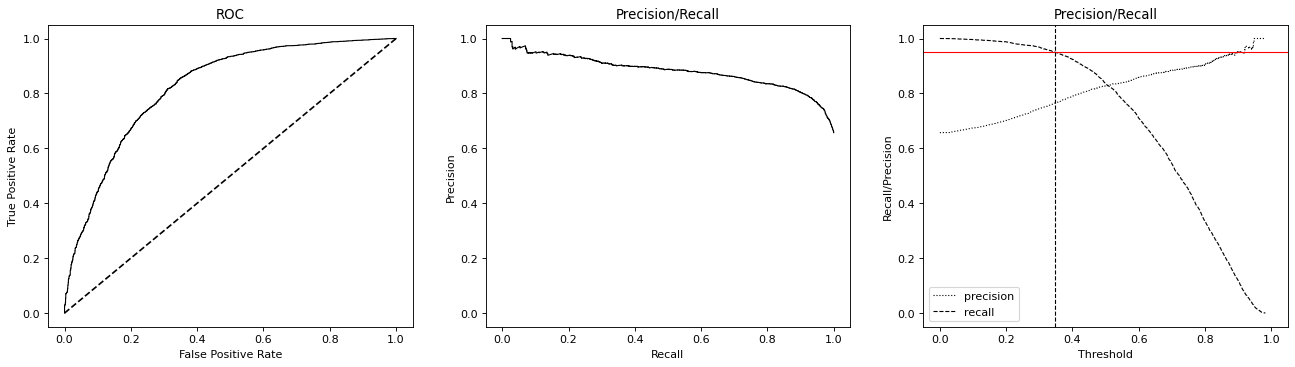

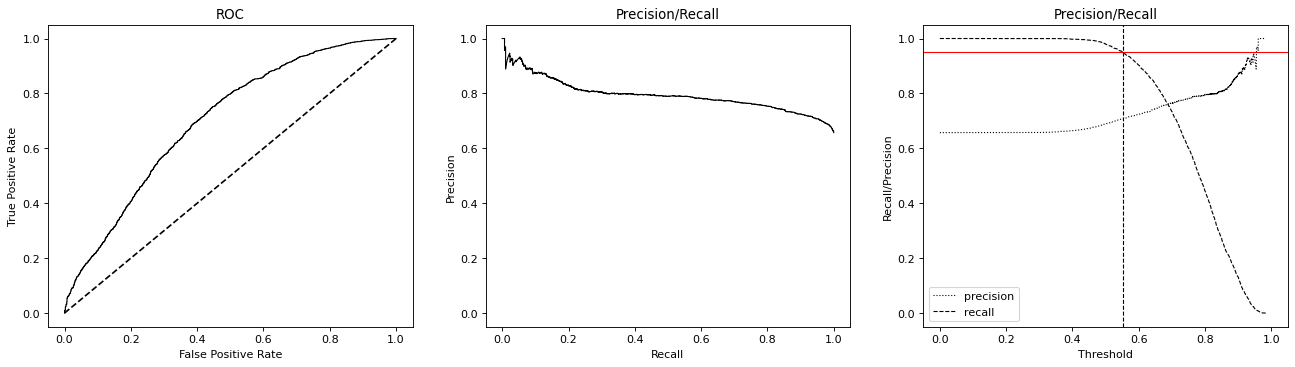

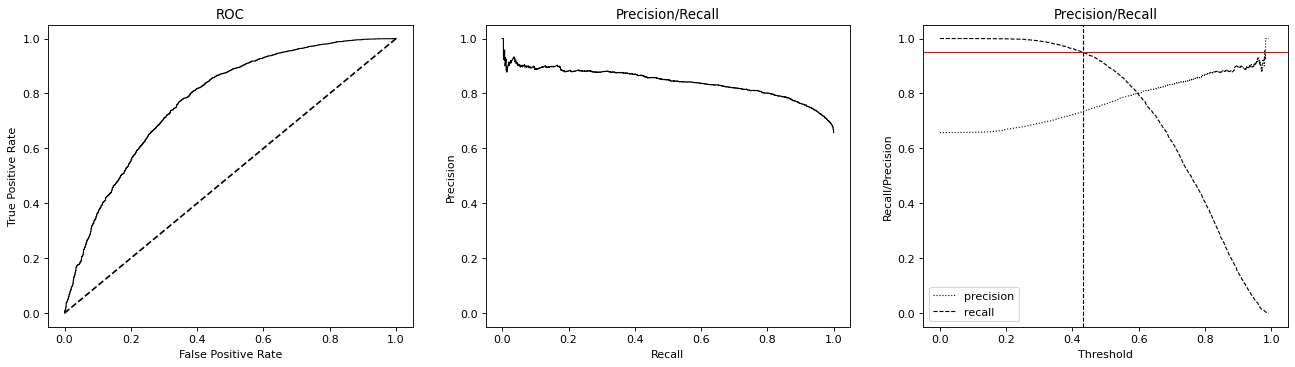

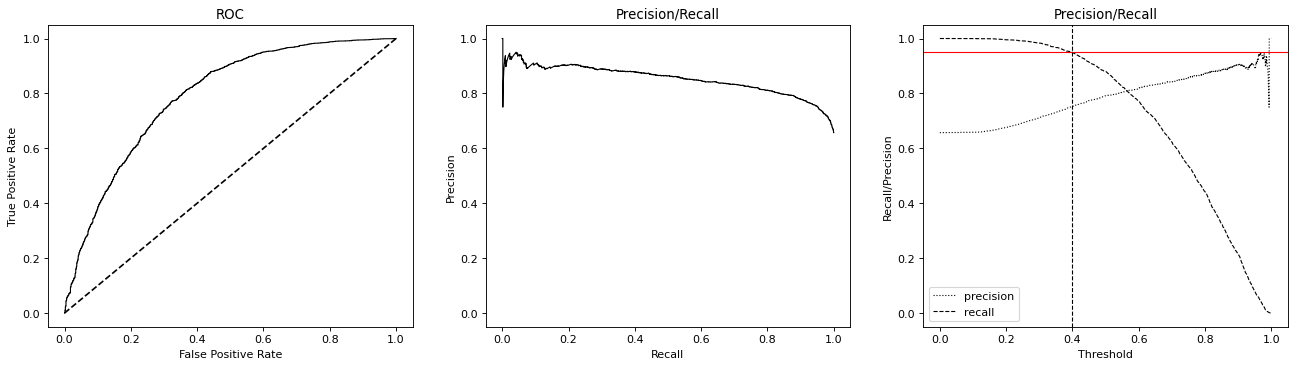

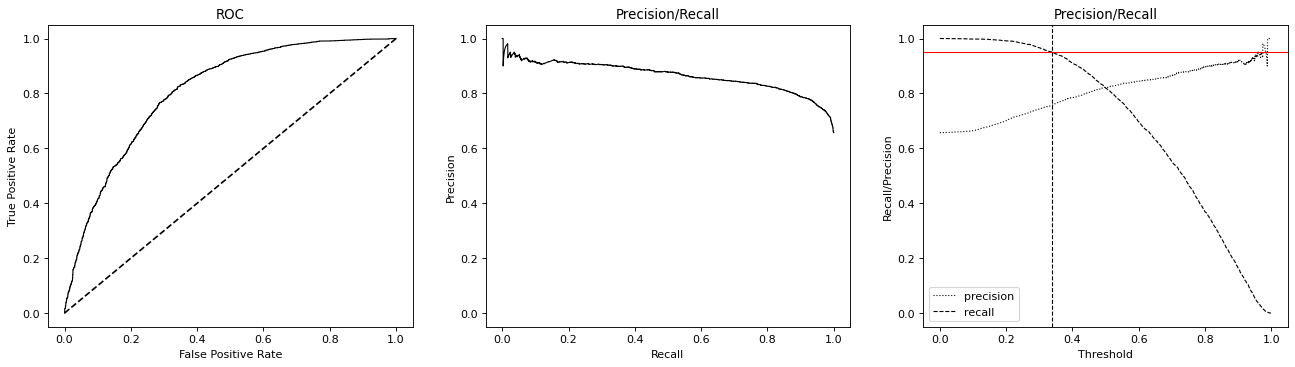

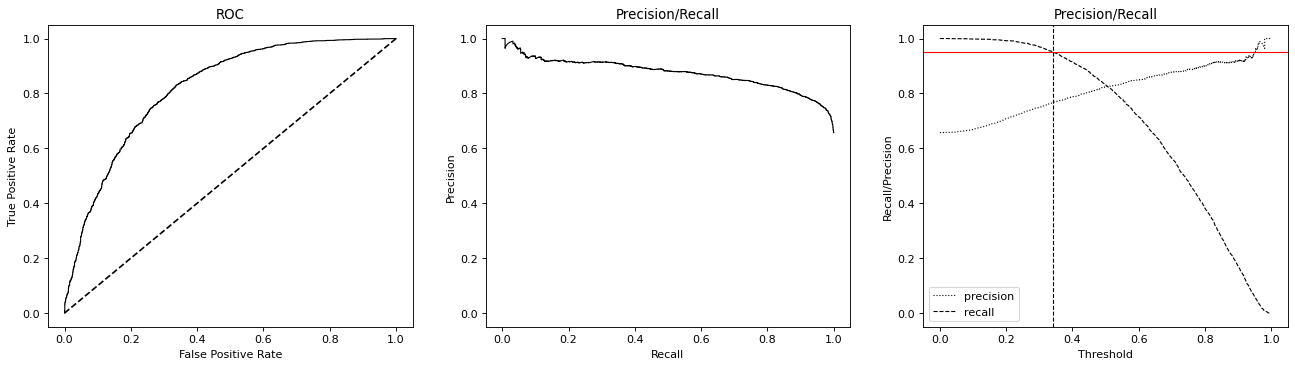

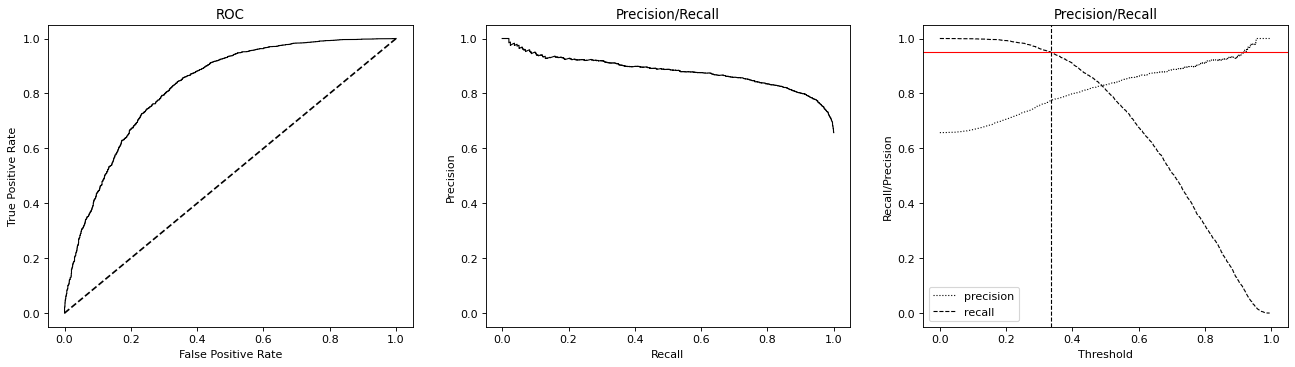

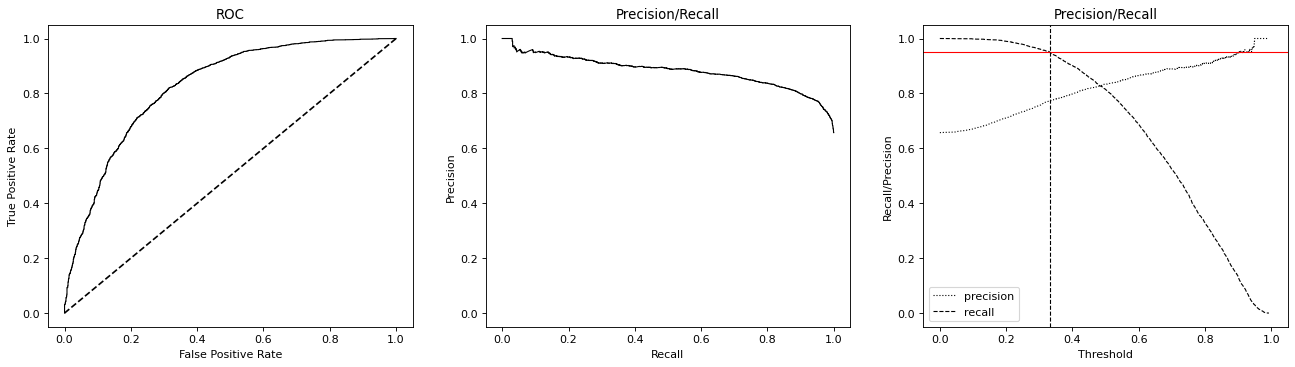

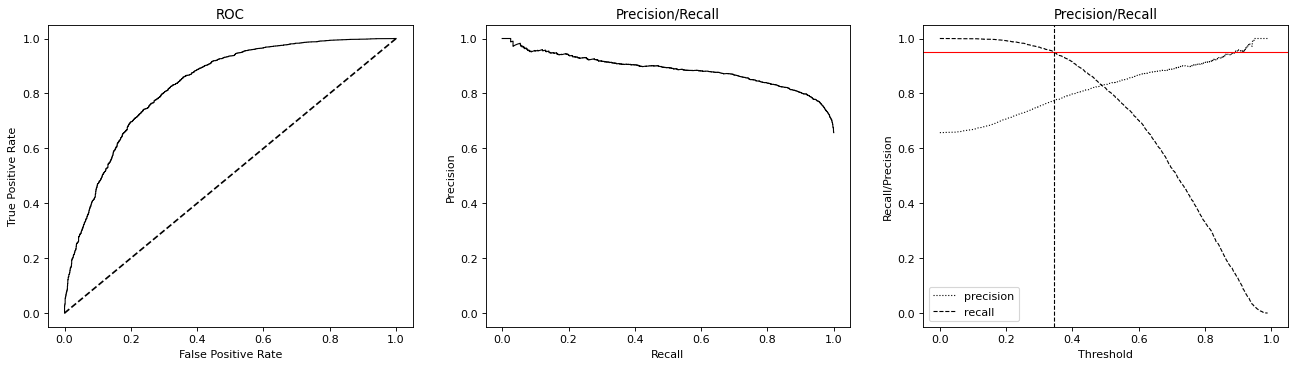

In [46]:
months = [i for i in range(1,9)]

queried_invoice_per_month = [(0.05, 'dotted'), (0.10, 'dashed'), (0.20, 'solid')]

performance_hist_uncertainty = []

for qinv in queried_invoice_per_month:

    performance_hist_uncertainty_ = []
    
    # Fit model
    al_uncertainty = ActiveLearner(
        estimator=BaggingClassifier(SVC(C=0.1, kernel='linear', probability=True), n_estimators=15),
        query_strategy=uncertainty_sampling,
        X_training=None, 
        y_training=None
    )
    
    for month in tqdm(months):

        month_data = df_bags_train_std_miles_pca[invoice_months == month].reset_index(drop=True)
        month_labels = y_bag_train[invoice_months == month]
    
        most_valuable_instances_idx, _ = al_uncertainty.query(month_data, n_instances=int(len(month_data)*qinv[0]))
        teached_idx = most_valuable_instances_idx.tolist()

        #al_uncertainty.teach(most_valuable_instances_data, month_labels[most_valuable_instances_idx])
        al_uncertainty.teach(month_data[month_data.index.isin(teached_idx)], month_labels[pd.Series(month_labels).index.isin(teached_idx)])

        # Predict on validation set
        y_bag_validation_pred = pd.DataFrame(al_uncertainty.predict_proba(df_bags_validation_std_miles_pca))
        # Evaluate prediction
        min_threshold, specificity, auc = model_evaluation(y_bag_validation, y_bag_validation_pred)

        performance_hist_uncertainty_ += [[min_threshold, specificity, auc]]
    
    performance_hist_uncertainty += [(qinv, performance_hist_uncertainty_)]

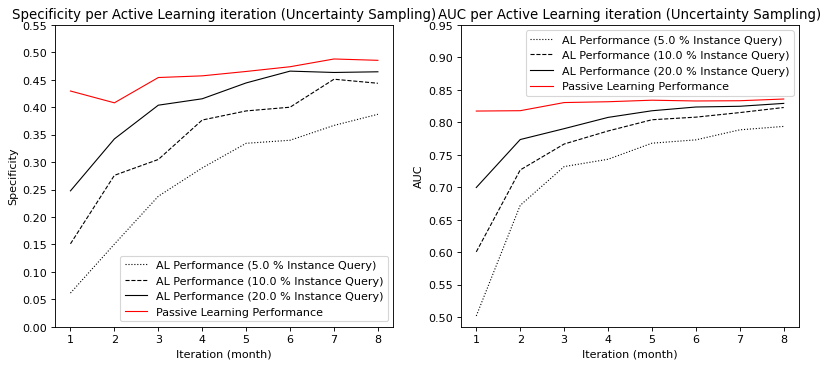

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

for qry in performance_hist_uncertainty:
    
    axs[0].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls=qry[0][1], label='AL Performance ({} % Instance Query)'.format(qry[0][0]*100))

    axs[1].plot(np.arange(1, 9, 1), [i[2] for i in qry[1]], lw=1, color='black', ls=qry[0][1], label='AL Performance ({} % Instance Query)'.format(qry[0][0]*100))

    
axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (Uncertainty Sampling)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[0].legend()

axs[1].plot(np.arange(1, 9, 1), auc_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Active Learning iteration (Uncertainty Sampling)', yticks=np.arange(.5, 1, .05), xticks=np.arange(1, 9, 1))
axs[1].legend()

### Plots

In [48]:
if True:
    warnings.warn('Fixed Uncertainty learning results')
    performance_hist_uncertainty = [((0.05, 'dotted'),
                                      [[0.5885275161663104, 8.476658476658477, 0.5457298856049257],
                                       [0.4028116582007548, 6.6339066339066335, 0.5899876165816569],
                                       [0.5037471808483945, 13.32923832923833, 0.6183687109672371],
                                       [0.39909713614299486, 23.157248157248155, 0.67441135464205],
                                       [0.36424240155214815, 27.94840294840295, 0.6896131224872013],
                                       [0.3767244368435635, 32.06388206388206, 0.7231603381074705],
                                       [0.3836559004667628, 34.45945945945946, 0.7471596075408955],
                                       [0.3767399487985773, 37.16216216216216, 0.7604442285634211]]),
                                     ((0.1, 'dashed'),
                                      [[0.5272808584474055, 12.039312039312039, 0.5630245534923523],
                                       [0.49184877076166217, 23.894348894348894, 0.7029357282481281],
                                       [0.37646957347741167, 30.651105651105652, 0.7660193253753009],
                                       [0.3097027961764242, 37.96068796068796, 0.7959640920230474],
                                       [0.31776659646702604, 42.26044226044226, 0.8117133911751022],
                                       [0.2998367568168694, 43.12039312039312, 0.8142957629500405],
                                       [0.3097240528926999, 43.85749385749386, 0.819549859200612],
                                       [0.305502328051469, 44.9017199017199, 0.8250521355295467]]),
                                     ((0.2, 'solid'),
                                      [[0.6159592532540373, 20.454545454545457, 0.6922169467827911],
                                       [0.39071209731248113, 30.405405405405407, 0.7604017171463502],
                                       [0.4004923737131002, 39.68058968058968, 0.8046279581845106],
                                       [0.35248956974148477, 44.533169533169534, 0.814517767016966],
                                       [0.34646773934989983, 46.990171990171994, 0.8233898603972298],
                                       [0.34157272293580637, 47.420147420147416, 0.8257392066267427],
                                       [0.3314533189085466, 46.4987714987715, 0.8265797911744723],
                                       [0.3412304469995504, 46.990171990171994, 0.8275461386643701]])]

C:\Users\Ward\AppData\Local\Temp\4\ipykernel_2248\3049613936.py:2: UserWarning: Fixed Uncertainty learning results
  warnings.warn('Fixed Uncertainty learning results')


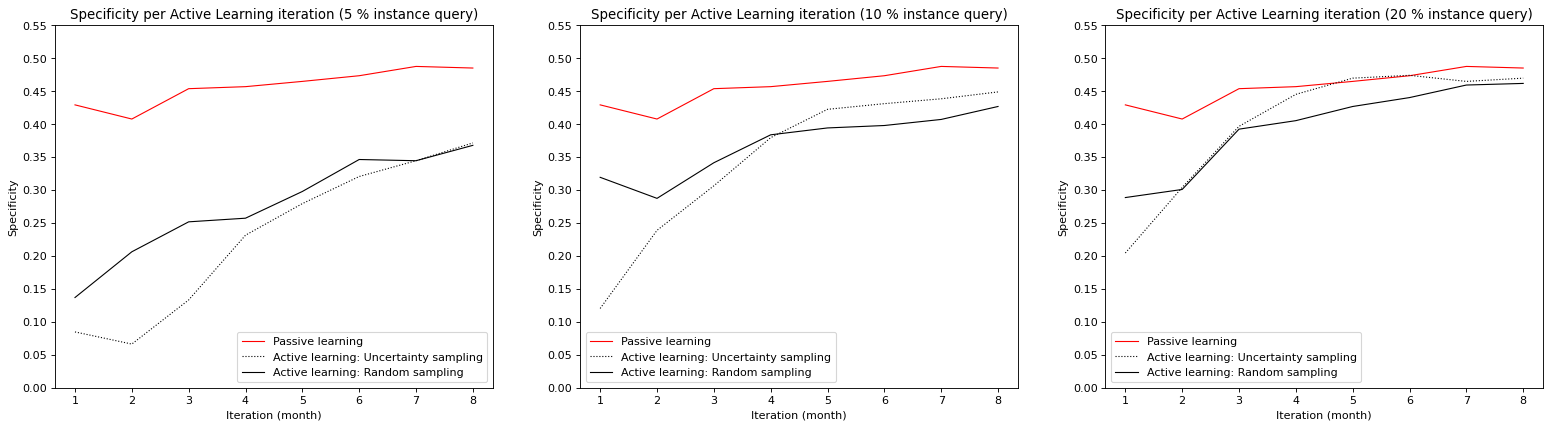

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), dpi=80)

sample_size_idx = 0

# Upper bound
axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[1].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[2].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')


for idx in [0, 1, 2]:

    # Uncertainty
    qry = performance_hist_uncertainty[idx]
    axs[idx].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dotted', label='Active learning: Uncertainty sampling')

    # Lower bound
    qry = performance_hist_random[idx]
    axs[idx].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

    axs[idx].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration ({:.0f} % instance query)'.format(performance_hist_uncertainty[idx][0][0]*100), yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
    axs[idx].legend()

In [50]:
# LaTeX
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_uncertainty[0][1]]]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_uncertainty[1][1]]]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_uncertainty[2][1]]]))

0.085& 0.066& 0.133& 0.232& 0.279& 0.321& 0.345& 0.372
0.12& 0.239& 0.307& 0.38& 0.423& 0.431& 0.439& 0.449
0.205& 0.304& 0.397& 0.445& 0.47& 0.474& 0.465& 0.47


## Query-by-committee

In [51]:
from modAL.models import ActiveLearner, Committee
from modAL.disagreement import *

 12%|██████████▌                                                                         | 1/8 [00:00<00:02,  3.14it/s]

AUC = 0.4809249697106154
Recall of 95.00 % reached on 0.595 threshold. This equals a 7.248 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.6041187265153942
Recall of 95.00 % reached on 0.269 threshold. This equals a 5.835 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7445679855965021
Recall of 95.00 % reached on 0.428 threshold. This equals a 31.880 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.6808107005960258
Recall of 95.00 % reached on 0.439 threshold. This equals a 17.260 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.6801084749658926
Recall of 95.00 % reached on 0.420 threshold. This equals a 21.560 % specificity


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:11<00:09,  3.09s/it]C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append 

AUC = 0.6888788164821488
Recall of 95.00 % reached on 0.341 threshold. This equals a 16.953 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7338726247729772
Recall of 95.00 % reached on 0.350 threshold. This equals a 26.044 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7641895631322098
Recall of 95.00 % reached on 0.337 threshold. This equals a 28.501 % specificity


 12%|██████████▌                                                                         | 1/8 [00:00<00:03,  2.13it/s]

AUC = 0.5865912298946583
Recall of 95.00 % reached on 0.429 threshold. This equals a 12.776 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.6596053759623128
Recall of 95.00 % reached on 0.376 threshold. This equals a 13.759 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7763450730448488
Recall of 95.00 % reached on 0.401 threshold. This equals a 29.177 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.785155564232783
Recall of 95.00 % reached on 0.382 threshold. This equals a 36.118 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.8010875050285495
Recall of 95.00 % reached on 0.352 threshold. This equals a 40.479 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7970190049651761
Recall of 95.00 % reached on 0.270 threshold. This equals a 39.189 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7994128307329205
Recall of 95.00 % reached on 0.252 threshold. This equals a 41.400 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.8037944588729593
Recall of 95.00 % reached on 0.254 threshold. This equals a 41.216 % specificity


 12%|██████████▌                                                                         | 1/8 [00:01<00:10,  1.53s/it]

AUC = 0.6629929061040883
Recall of 95.00 % reached on 0.524 threshold. This equals a 18.857 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7825613837308807
Recall of 95.00 % reached on 0.299 threshold. This equals a 31.265 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.7964157758294254
Recall of 95.00 % reached on 0.347 threshold. This equals a 35.074 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.8021804027090794
Recall of 95.00 % reached on 0.310 threshold. This equals a 38.084 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.8074065516391694
Recall of 95.00 % reached on 0.262 threshold. This equals a 39.496 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.8096535555683264
Recall of 95.00 % reached on 0.242 threshold. This equals a 39.988 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.8140547665139142
Recall of 95.00 % reached on 0.239 threshold. This equals a 41.216 % specificity


C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0].append(blocks[1:])
C:\Users\Ward\AppData\Roaming\Python\Python39\site-packages\modAL\utils\data.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return blocks[0]

AUC = 0.817906674843554
Recall of 95.00 % reached on 0.241 threshold. This equals a 42.322 % specificity


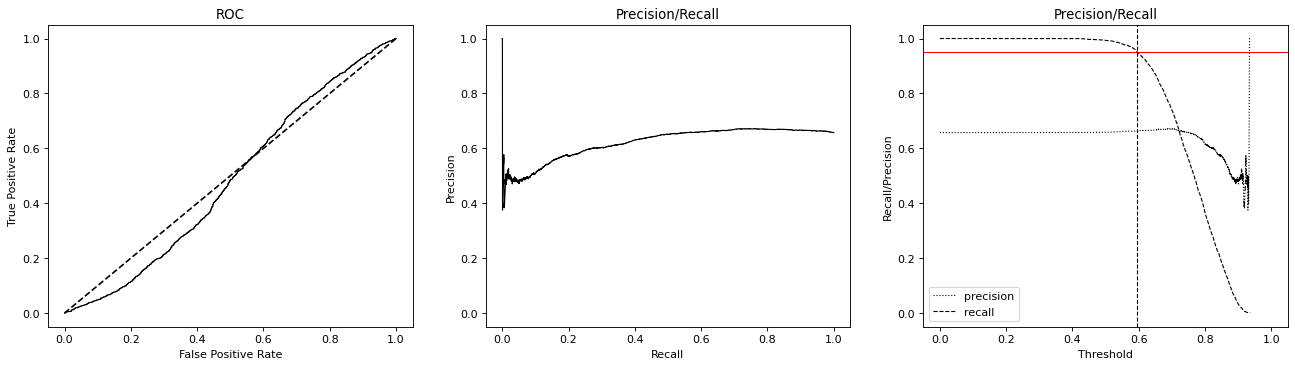

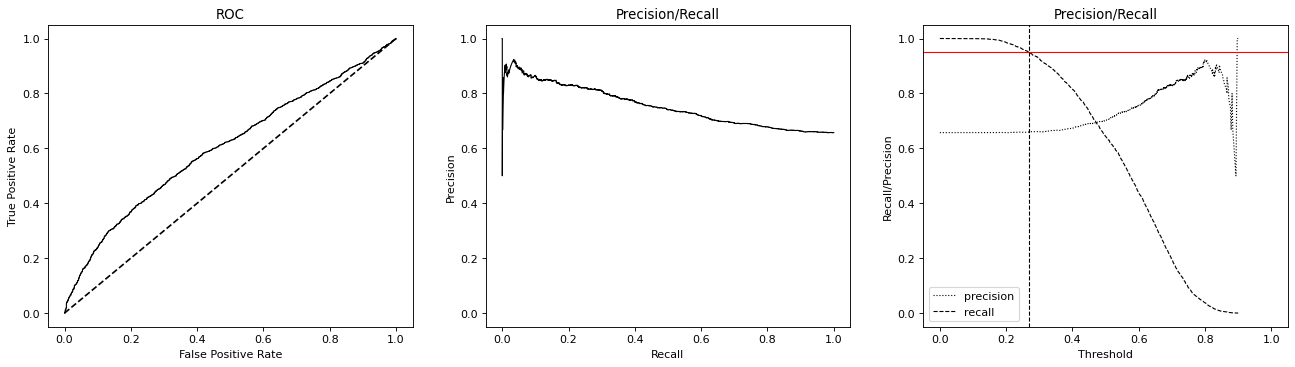

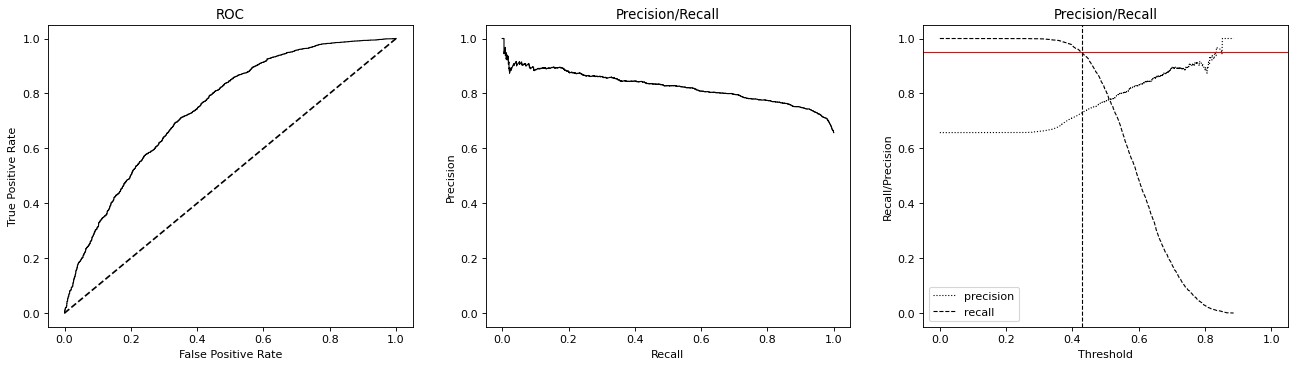

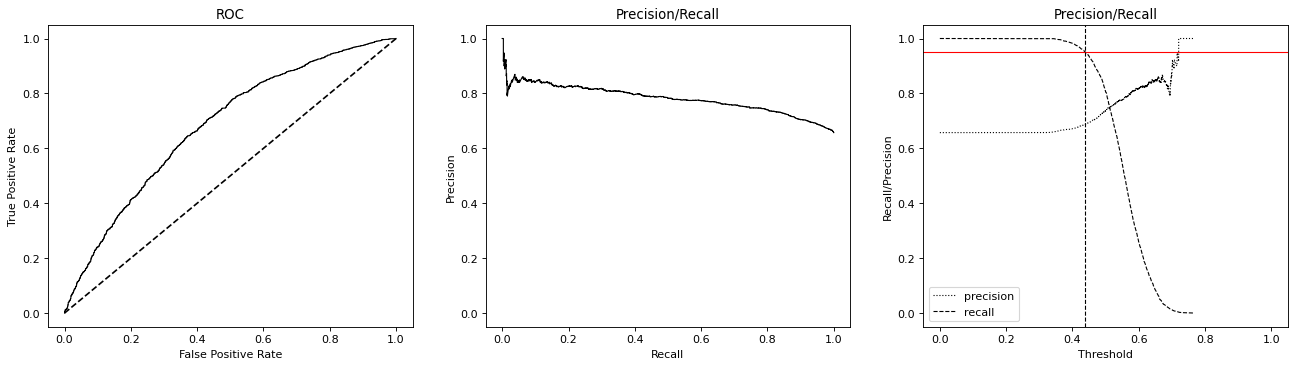

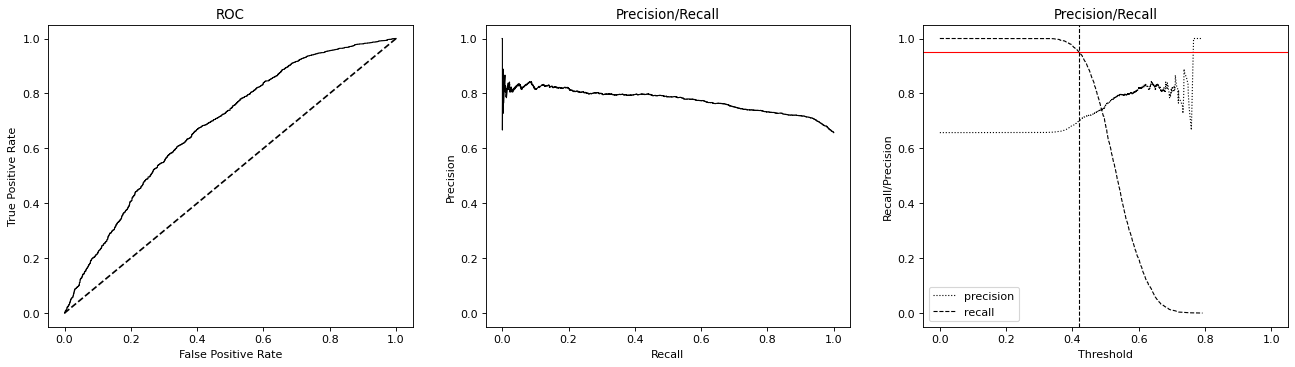

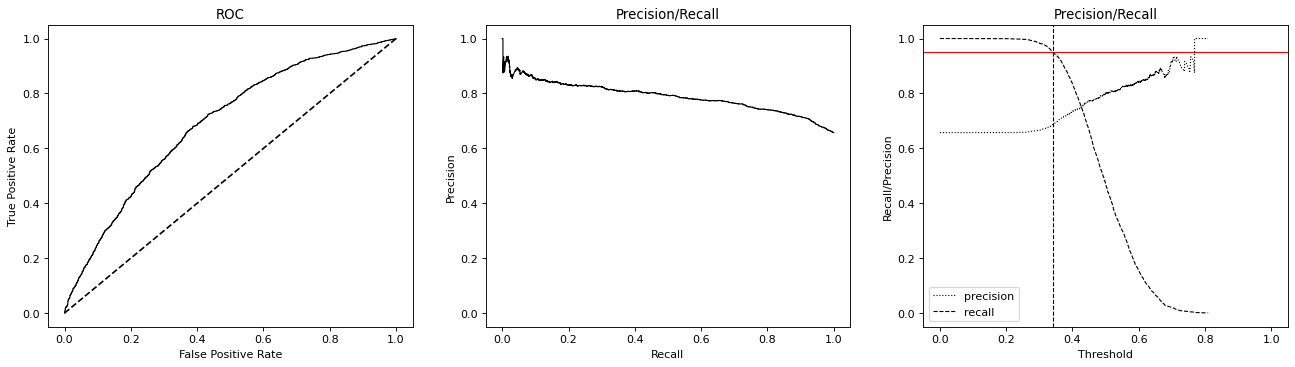

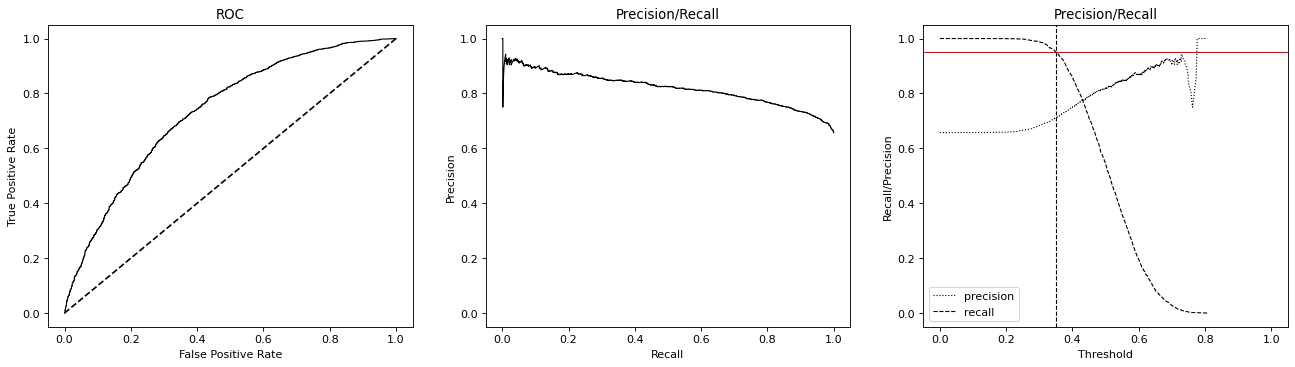

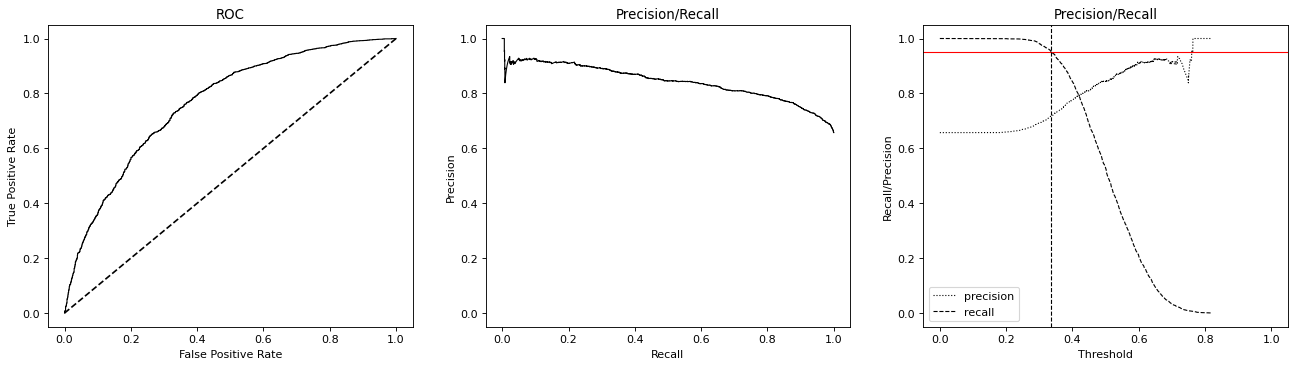

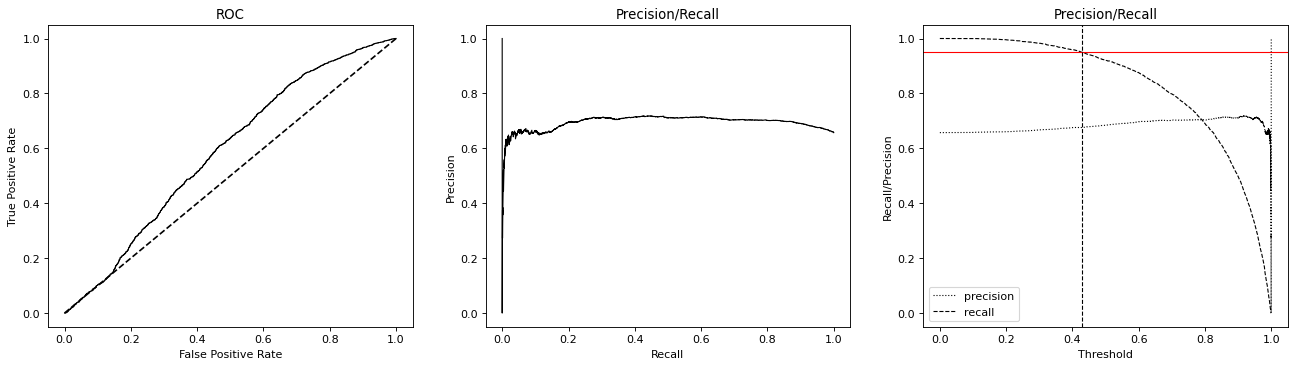

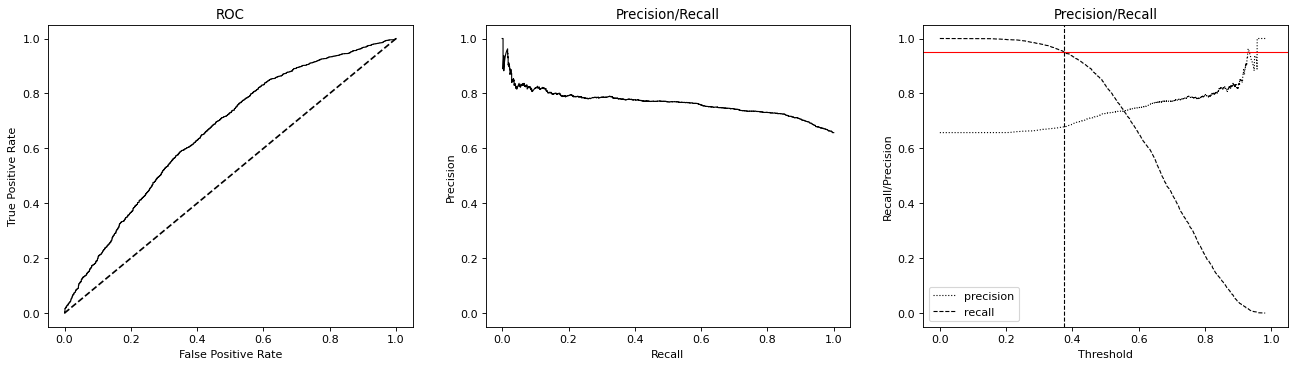

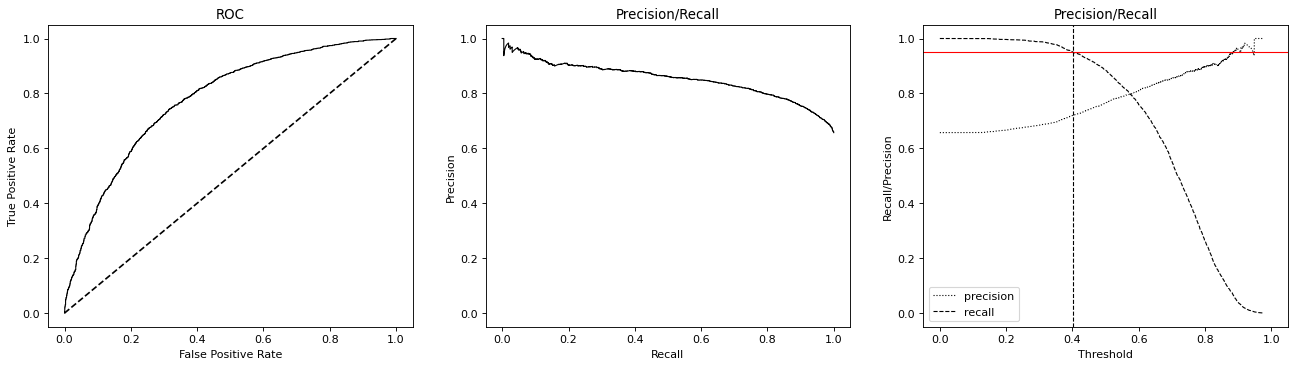

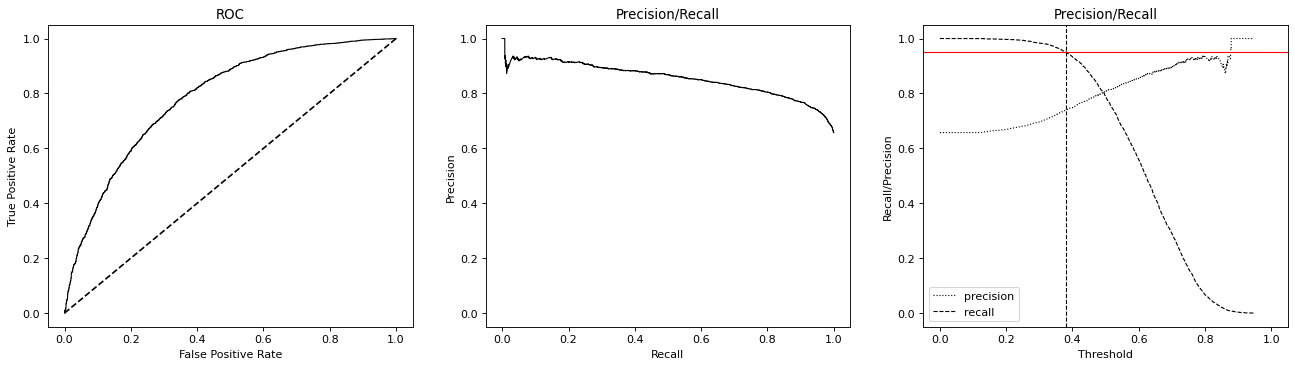

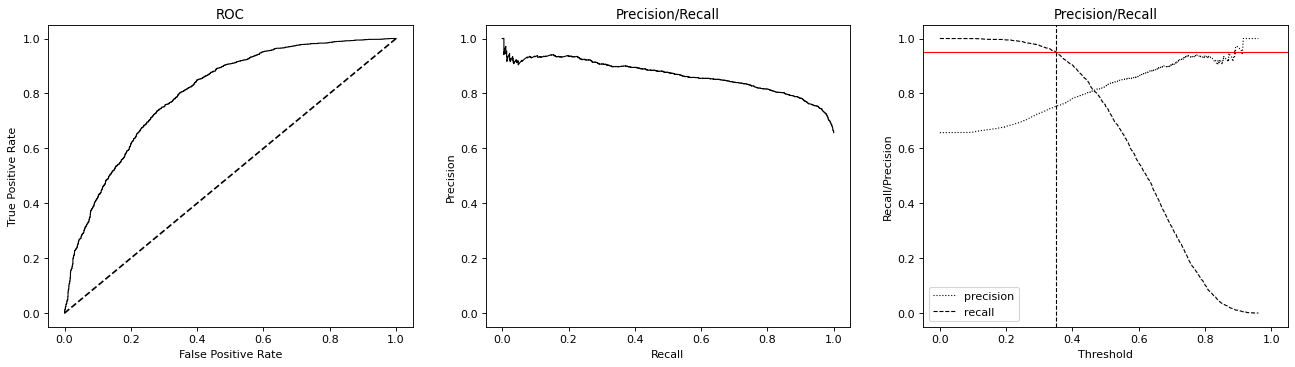

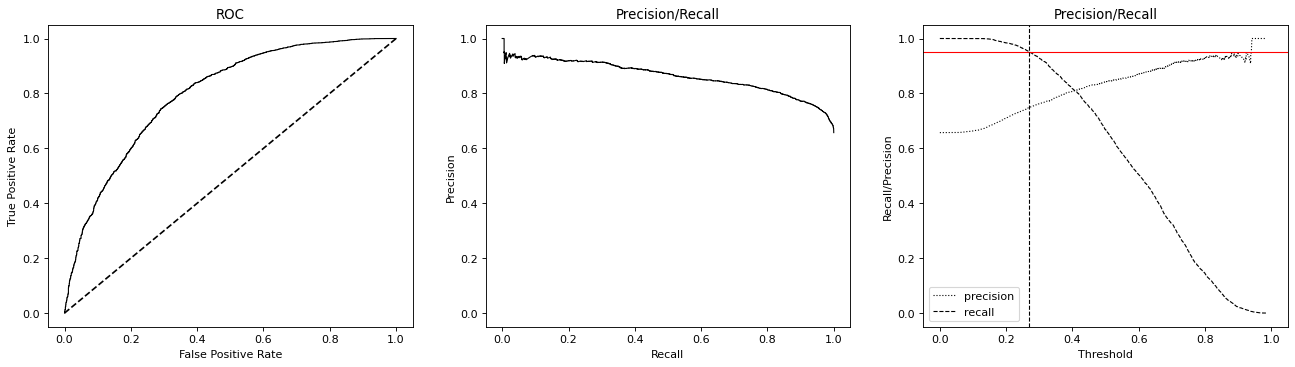

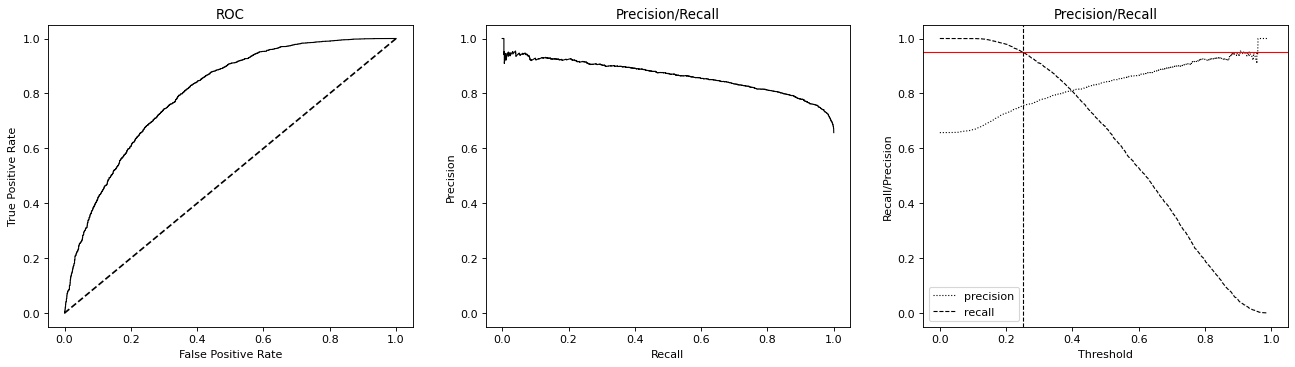

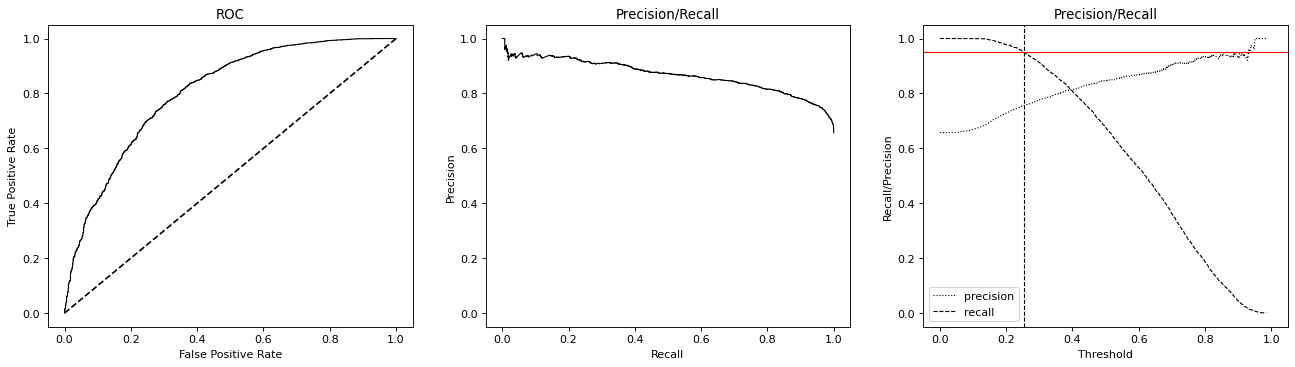

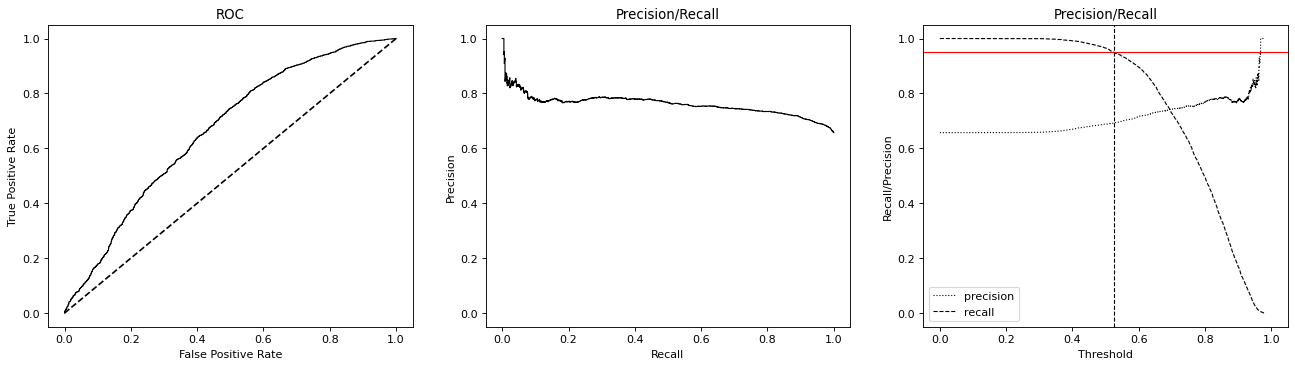

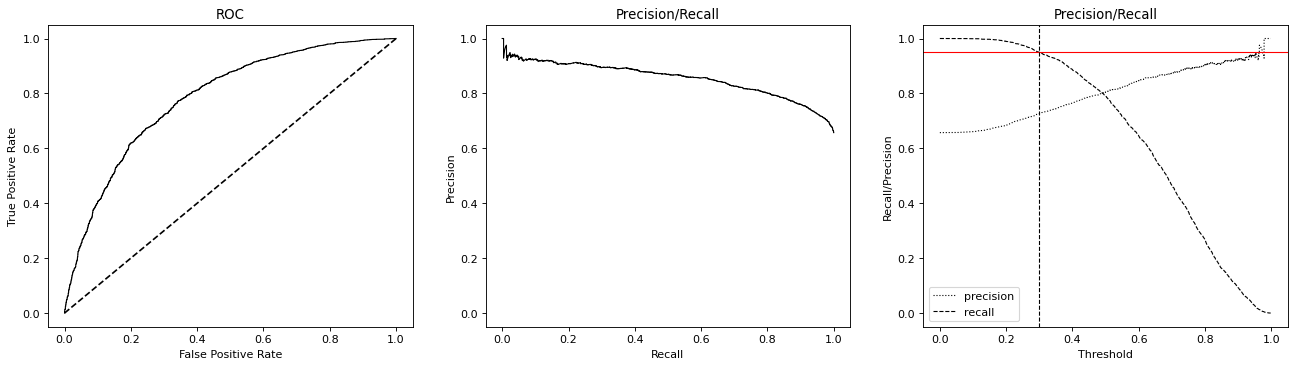

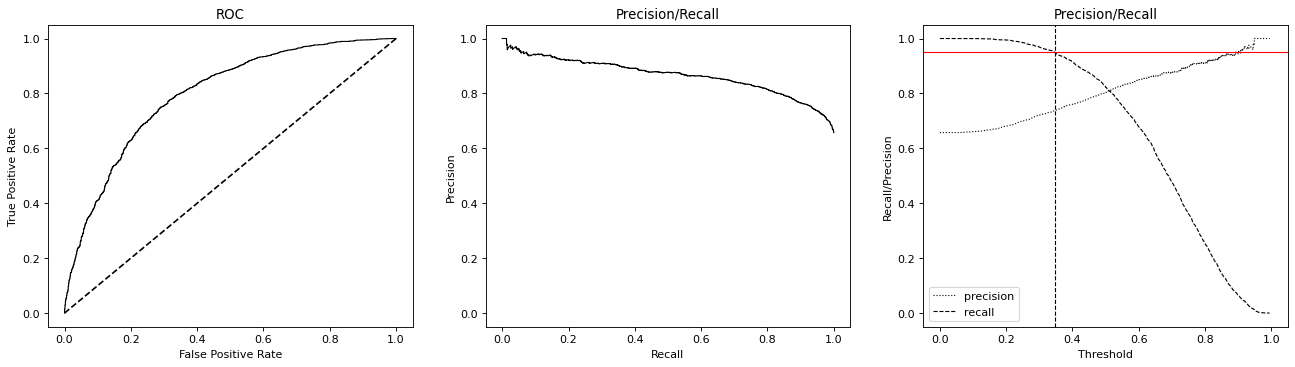

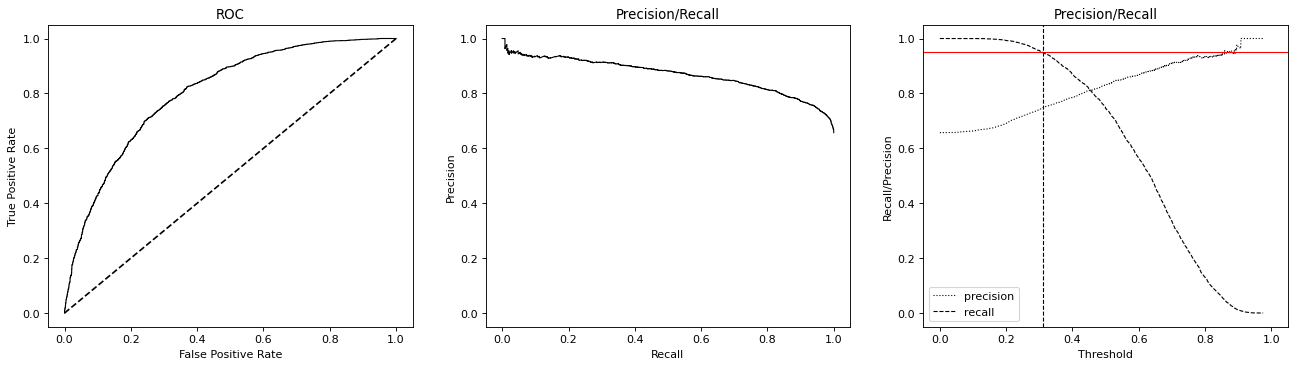

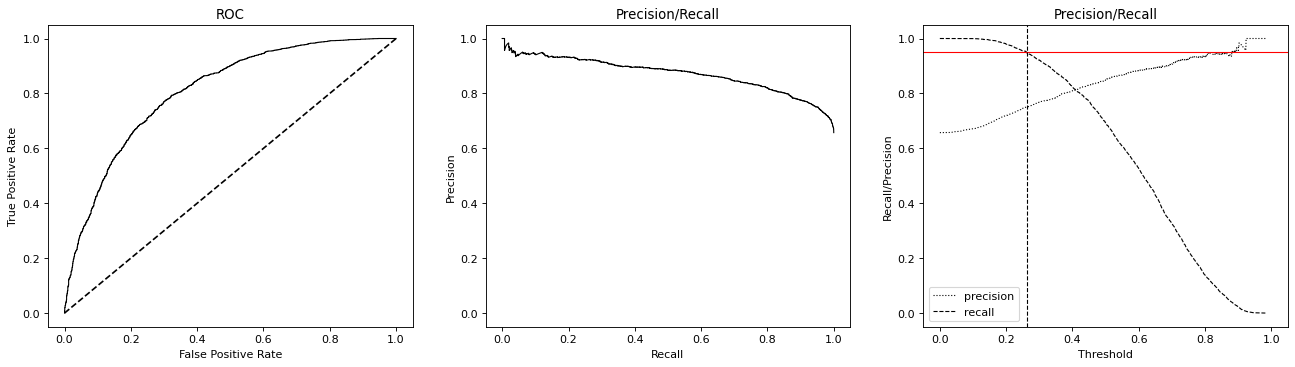

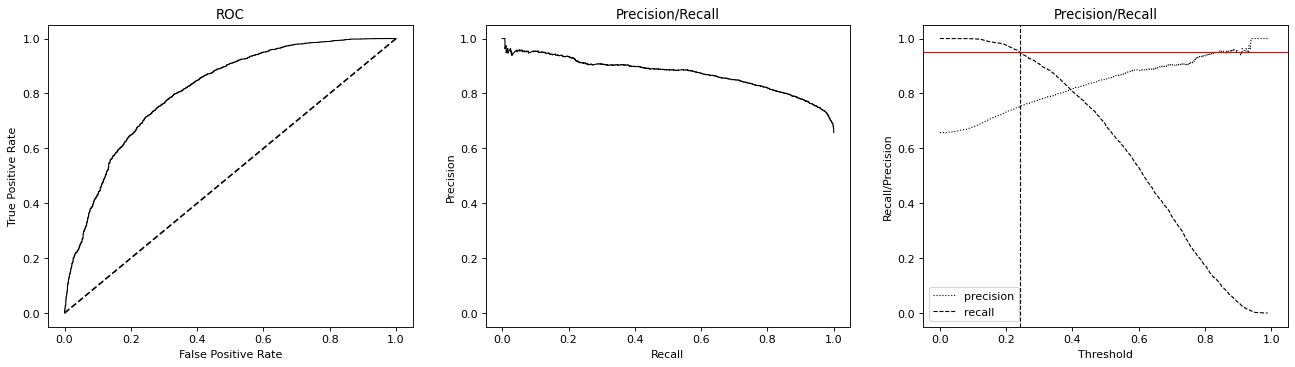

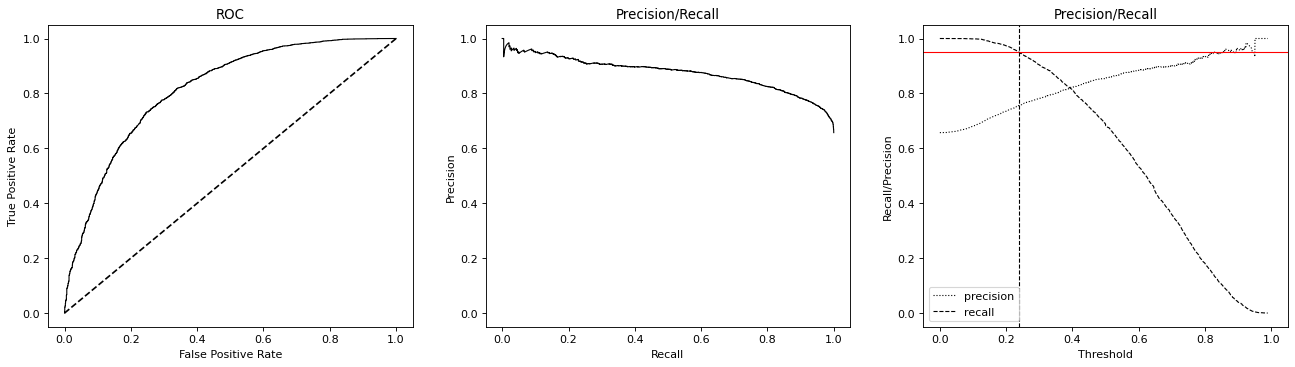

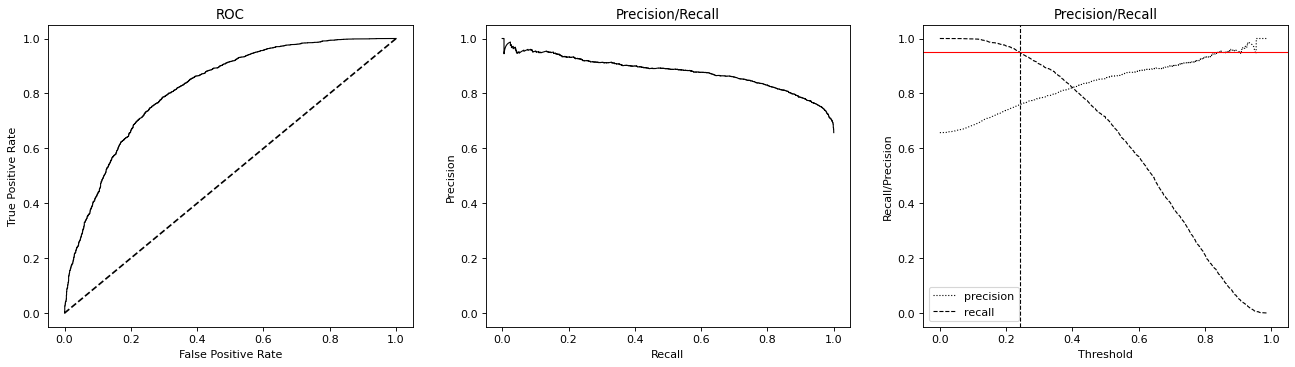

In [111]:
months = [i for i in range(1,9)]

queried_invoice_per_month = [(0.05, 'dotted'), (0.10, 'dashed'), (0.20, 'solid')]

performance_hist_qbc = []

for qinv in queried_invoice_per_month:

    performance_hist_qbc_ = []
    
    # Fit model
    # al_qbc = Committee([ActiveLearner(
    #                         estimator=BaggingClassifier(SVC(C=0.1, kernel='linear', probability=True), n_estimators=15),
    #                         X_training=None, 
    #                         y_training=None
    #                     )], query_strategy=vote_entropy_sampling)
    al_qbc = Committee([ActiveLearner(
                            estimator=SVC(C=0.1, kernel='linear', probability=True),
                            bootstrap_init=True
                        ) for _ in range(15)], query_strategy=max_disagreement_sampling)
    
    for month in tqdm(months):
    
        month_data = df_bags_train_std_miles_pca[invoice_months == month].reset_index(drop=True)
        month_labels = y_bag_train[invoice_months == month]

        most_valuable_instances_idx, _ = al_qbc.query(month_data, n_instances=int(len(month_data)*qinv[0]))
        teached_idx = most_valuable_instances_idx.tolist()
        
        #al_qbc.teach(most_valuable_instances_data, month_labels[most_valuable_instances_idx])
        al_qbc.teach(month_data[month_data.index.isin(teached_idx)], month_labels[pd.Series(month_labels).index.isin(teached_idx)])
        
        # Predict on validation set
        y_bag_validation_pred = pd.DataFrame(al_qbc.predict_proba(df_bags_validation_std_miles_pca))
        # Evaluate prediction
        min_threshold, specificity, auc = model_evaluation(y_bag_validation, y_bag_validation_pred)
        
        performance_hist_qbc_ += [[min_threshold, specificity, auc]]
    
    performance_hist_qbc += [(qinv, performance_hist_qbc_)]

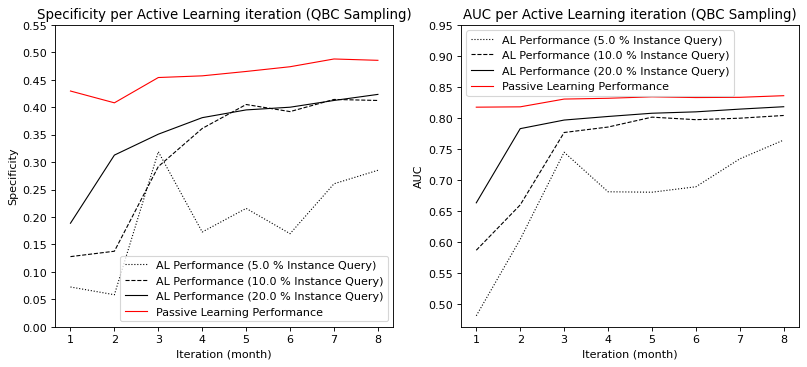

In [112]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=80)

for qry in performance_hist_qbc:
    
    axs[0].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls=qry[0][1], label='AL Performance ({} % Instance Query)'.format(qry[0][0]*100))

    axs[1].plot(np.arange(1, 9, 1), [i[2] for i in qry[1]], lw=1, color='black', ls=qry[0][1], label='AL Performance ({} % Instance Query)'.format(qry[0][0]*100))

    
axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[0].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (QBC Sampling)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs[0].legend()

axs[1].plot(np.arange(1, 9, 1), auc_evolution_passive, lw=1, color='red', ls='solid', label='Passive Learning Performance')
axs[1].set(xlabel='Iteration (month)', ylabel='AUC', title='AUC per Active Learning iteration (QBC Sampling)', yticks=np.arange(.5, 1, .05), xticks=np.arange(1, 9, 1))
axs[1].legend()

### Plots

In [101]:
if True:
    warnings.warn('Fixed QBC learning results')
    performance_hist_qbc = [((0.05, 'dotted'),
          [[0.5741666614261866, 7.2481572481572485, 0.4809249697106154],[0.1918090389332792, 5.896805896805897, 0.6122065236131241],
           [0.40076076096646085, 25.307125307125304, 0.7336874245717566],[0.3565777331481282, 21.990171990171987, 0.7124299447272853],
           [0.34611206330057587, 28.992628992628994, 0.7537183713088873],[0.33049747692581827, 33.108108108108105, 0.779960708429148],
           [0.2958542469096568, 27.94840294840295, 0.7548461047339613],[0.2680411793328281, 28.00982800982801, 0.7547661990148373]]),
         ((0.1, 'dashed'),
          [[0.4416305995352615, 12.776412776412776, 0.5865914267067744],[0.3841074190706737, 22.91154791154791, 0.6953232324107043],
           [0.31298897602864806, 30.58968058968059, 0.7729593142121178],[0.2876471328525457, 38.022113022113025, 0.7962957204386234],
           [0.26526007774096416, 41.584766584766584, 0.7996108237216857],[0.26426966126450807, 40.54054054054054, 0.8056242211160506],
           [0.2611753417159858, 41.95331695331696, 0.8030446047107374],[0.264513910067918, 41.76904176904177, 0.8054089086610714]]),
         ((0.2, 'solid'),
          [[0.5212944885465824, 18.857493857493857, 0.6629950710373651],[0.326298119462633, 32.55528255528255, 0.7818203861138817],
           [0.36202385600411735, 32.186732186732186, 0.7961237066491792],[0.29127507886925125, 36.17936117936118, 0.8043195535986308],
           [0.25268336902553323, 38.57493857493858, 0.8089556598047466],[0.23816515389872314, 39.74201474201474, 0.8106753056688975],
           [0.23769482737013378, 40.35626535626536, 0.8177288550966859],[0.22690056697879551, 40.54054054054054, 0.8173736092271818]])]

C:\Users\Ward\AppData\Local\Temp\4\ipykernel_2248\4198860890.py:2: UserWarning: Fixed QBC learning results
  warnings.warn('Fixed QBC learning results')


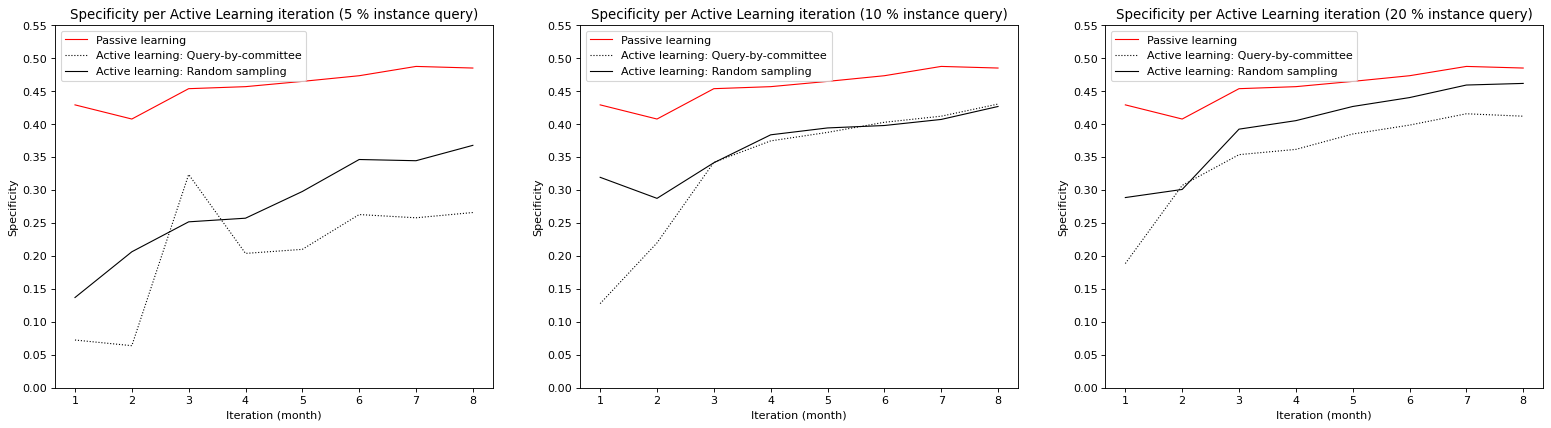

In [110]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), dpi=80)

sample_size_idx = 0

# Upper bound
axs[0].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[1].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')
axs[2].plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning')


for idx in [0, 1, 2]:

    # QBC
    qry = performance_hist_qbc[idx]
    axs[idx].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dotted', label='Active learning: Query-by-committee')

    # Lower bound
    qry = performance_hist_random[idx]
    axs[idx].plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

    axs[idx].set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration ({:.0f} % instance query)'.format(performance_hist_qbc[idx][0][0]*100), yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
    axs[idx].legend()

In [ ]:
# LaTeX
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_qbc[0][1]]]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_qbc[1][1]]]))
print('& '.join([str(round(i, 3)) for i in [i[1]/100 for i in performance_hist_qbc[2][1]]]))

## Plots

### 5 % instance query

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), dpi=80)

sample_size_idx = 0

# Upper bound
axs.plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning performance')

# Lower bound
qry = performance_hist_random[sample_size_idx]
axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

# Uncertainty
qry = performance_hist_uncertainty[sample_size_idx]
axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dotted', label='Active learning: Uncertainty sampling')

# QBC
# qry = performance_hist_qbc[sample_size_idx]
# axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dashed', label='Active learning: Query-by-committee')


axs.set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (5 % instance query)', yticks=np.arange(.0, .6, .05), xticks=np.arange(1, 9, 1))
axs.legend()

### 10 % instance query

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), dpi=80)

sample_size_idx = 1

# Upper bound
axs.plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning performance')

# Lower bound
qry = performance_hist_random[sample_size_idx]
axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

# Uncertainty
qry = performance_hist_uncertainty[sample_size_idx]
axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dotted', label='Active learning: Uncertainty sampling')

# QBC
# qry = performance_hist_qbc[sample_size_idx]
# axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dashed', label='Active learning: Query-by-committee')


axs.set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (10 % Instance Query)', yticks=np.arange(.1, .6, .05), xticks=np.arange(1, 9, 1))
axs.legend()

### 20 % instance query

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), dpi=80)

sample_size_idx = 2

# Upper bound
axs.plot(np.arange(1, 9, 1), specificity_evolution_passive, lw=1, color='red', ls='solid', label='Passive learning performance')

# Lower bound
qry = performance_hist_random[sample_size_idx]
axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='solid', label='Active learning: Random sampling')

# Uncertainty
qry = performance_hist_uncertainty[sample_size_idx]
axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dotted', label='Active learning: Uncertainty sampling')

# QBC
# qry = performance_hist_qbc[sample_size_idx]
# axs.plot(np.arange(1, 9, 1), [i[1]/100 for i in qry[1]], lw=1, color='black', ls='dashed', label='Active learning: Query-by-committee')


axs.set(xlabel='Iteration (month)', ylabel='Specificity', title='Specificity per Active Learning iteration (20 % Instance Query)', yticks=np.arange(.2, .6, .05), xticks=np.arange(1, 9, 1))
axs.legend()

In [ ]:
diff = np.array(specificity_evolution_uncertainty_20) - np.array(specificity_benchmark)
print([round(i, 3) for i in diff])
diff_absolute = diff*800
print(diff_absolute)
print(diff_absolute.sum())

In [ ]:
(np.array(specificity_benchmark)*329).sum()

In [ ]:
(np.array(specificity_evolution_uncertainty_20)*329).sum()-(np.array(specificity_benchmark)*329).sum()

In [ ]:
'& '.join([str(round(i, 2)) for i in diff])